# LSTM Pulsation Tracing (Colab)

This notebook trains a bidirectional LSTM to trace cardiac pulsations in optical waveforms (e.g., NIRS/DCS) and mitigate noise and artifacts. For questions, please contact Jingyi Wu (jingyiwu@andrew.cmu.edu) or Shaojie Bai (shaojieb@alumni.cmu.edu).

## General pipline:
- Load training data from `.npz` shards.
- Train an LSTM detection model.
- Inspect losses and qualitative examples.
- Export a checkpoint usable by the testing notebook.




## Import packages

In [ ]:
# Uncomment the next line to install your repo dependencies.
# !pip install -r requirements_train.txt

In [2]:
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn.functional as F
import scipy
from scipy.io import loadmat
import h5py
import numpy as np
import random
import gdown
import os
import math

## 1. Load dataset

Here we load a small `.npz` dataset prepared for demonstrating the training pipeline.  
- This example dataset is included in the GitHub repository.  
- For full-scale training, please download the larger dataset from [CMU KiltHub](link-to-dataset).  

Users have two options for Colab:
1. Download directly from GitHub.  
2. Upload the `.npz` file to your your own Google Drive and access it from there.  


In [3]:
# Mount drive for loading and saving data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data

# Option 1: Download example dataset directly from GitHub
# (uncomment and update URL to the raw .npz file)
# !wget -O example_dataset.npz "https://github.com/jingyiwu-biophotonics/LSTM-Pulsation-Tracing/raw/refs/heads/main/training/data/example_dataset_for_training.npz"

# Option 2: Save then Load from your own Google Drive.
# Assume the file is already in your Google Drive with the path:
data_path = '/content/drive/MyDrive/Colab Notebooks/LSTM-Pulse-Tracing/training_data/example_dataset_for_training.npz'
data_dict = np.load(data_path)
dataset = data_dict['data']
print(dataset.shape) # should be (750, 3000, 2)

# Convert to tensor
data = torch.from_numpy(dataset).float()

(750, 3000, 2)


## 2. Data Processing and Visualization

We organized the data in the following format: `[num_samples x sequence_len x feature_dim]`. In this example dataset:
  - There are 750 synthetic samples, grouped by 3 types:
    - Samples 0-249 → single peak pulses.
    - Samples 250-499 → closely spaced double peaks.
    - Samples 500-750 → widely spaced double peaks.
  - Each sample is a times series of length 3000, corresponding to 60-second signals sampled at 50 Hz.
  - The feature dimension is 1 (i.e., scalar data).

For each sample, there are 2 corresponding time series:
1. Processed (normalized) noisy signal (dim 0).
2. Clean (ground truth) signal (dim 1).

Therefore, the data we have can be reorganized into a tensor of shape $\mathbb{R}^{N \times 3000 \times 2}$, with `N = 3000` in this example.

**Normalization:**
We have also done some pre-scaled such that the clean signals range roughly within [−1, 1]. When we eventually apply the model on a real time-series, it is important that we keep this normalization as a preprocessing step (see testing notebook).

### Example visualization

To build intuition, we visualize an example trial. Below, we visualize the 21st time series (`idx=20`) from $t=20 s$ to $t=40 s$:


************************************************************
Visualizing data #20 from t=20 to t=40
************************************************************


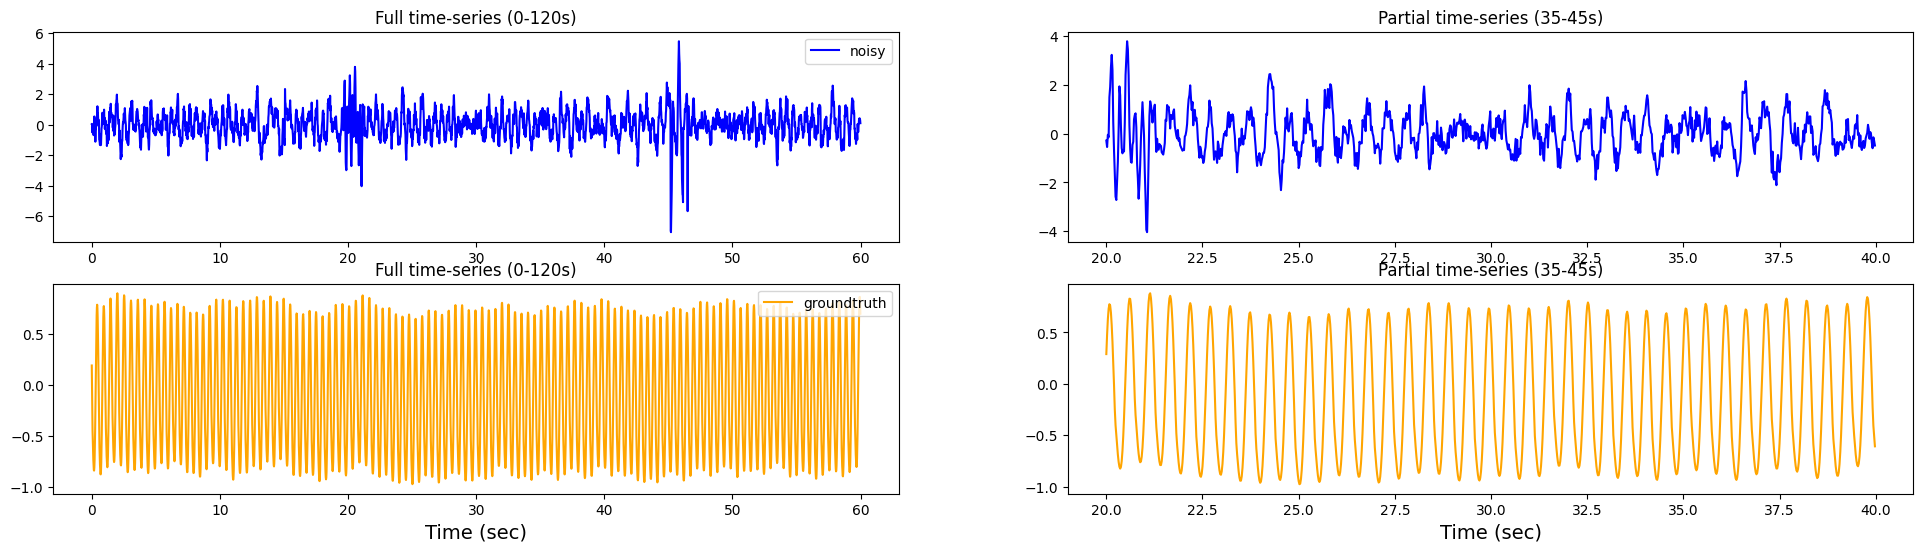

In [5]:
def visualize_segment(start, end, idx=random.randint(0, data.shape[0]), freq=50):
    # start, end: Start and end of the interval we want to visualize
    # idx: Index of the data sample we want to visualize
    # freq: Frequency of the data sample (shouldn't need to change this)
    fig, axs = plt.subplots(2,2,figsize=(24,6))
    interval = slice(start*freq, end*freq)
    axs[0][0].plot(np.arange(0, 60, 1./freq), data[idx,:,0], label="noisy", color="blue")
    axs[0][0].set_title("Full time-series (0-120s)")
    axs[0][1].plot(np.arange(start, end, 1./freq), data[idx,interval,0], label="noisy", color="blue")
    axs[0][1].set_title("Partial time-series (35-45s)")
    axs[0][0].legend(loc="upper right")
    axs[1][0].plot(np.arange(0, 60, 1./freq), data[idx,:,1], label="groundtruth", color="orange")
    axs[1][0].set_title("Full time-series (0-120s)")
    axs[1][1].plot(np.arange(start, end, 1./freq), data[idx,interval,1], label="groundtruth", color="orange")
    axs[1][1].set_title("Partial time-series (35-45s)")
    axs[1][0].legend(loc="upper right")
    axs[1][0].set_xlabel('Time (sec)', fontsize=14);
    axs[1][1].set_xlabel('Time (sec)', fontsize=14);
    print("*"*60 + "\n" f"Visualizing data #{idx} from t={start} to t={end}\n" + "*"*60)
    plt.show()

visualize_segment(20, 40, idx=20)

## 3. Create Dataset and Dataloader

We now need to organize the data into a dataset (and a loader of this dataset). Specifically:
  - We need to split the data into a training set and a validation/testing set. For example, we can use 85% of the data as training data (thus `percentage=85` below) and the rest as test data.
  - During training, we want to shuffle the data as well to avoid overfitting on any one or two particular kinds of noise.

In [6]:
# data has shape [number or time-series x 3000 x 2]
new_data_x = data[..., 0:1].float()   # x (input) should be the noisy time-series
new_data_y = data[..., 1:].float()    # y (target) should be the clean time-series

random.seed(42)
order = np.random.permutation(list(range(new_data_x.shape[0])))
new_data_x = new_data_x[order]
new_data_y = new_data_y[order]
print(f"New dataset has shape {new_data_x.shape}")

class PulseDataset(Dataset):
    def __init__(self, data_x, data_y, order):
        super().__init__()
        self.data_x = data_x
        self.data_y = data_y
        self.order = order

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, idx):
        return self.data_x[idx], self.data_y[idx], (order[idx] // 10000) + 1

percentage = 85   # percent of data used for training
batch_size = 24
num_train = int(new_data_x.shape[0] * 0.01 * percentage)
pulse_train = DataLoader(PulseDataset(new_data_x[:num_train], new_data_y[:num_train], order[:num_train]), batch_size=batch_size, shuffle=True)
pulse_test = DataLoader(PulseDataset(new_data_x[num_train:], new_data_y[num_train:], order[num_train:]), batch_size=batch_size, shuffle=False)
print("Data ready!")

New dataset has shape torch.Size([750, 3000, 1])
Data ready!


## 4. Model Construction

We use a Long Short-Term Memory (LSTM) deep learning model [Hochreiter & Schmidhuber 1997], with the first few layers augmented by temporal convolutions (because the samples were densely generated, we want to include nearby influence in our prediction as well).

We also include below some other options of temporal model, such as the Transformers [Vaswani et al. 2017], in case you are interested in trying. However, there are some important reasons why we picked LSTMs:

- Transformers are well-known to be powerful but also data-hungry. Given the limited data, Transformers will more easily overfit and suffer from poor generalization.

- For a sequence of length $L$, a Transformer network needs to compute an (actually, $M$, where $M$ is the number of attention heads) attention matrix of size $L \times L$ every layer. Since $L=3000$ in our case, this implies huge memory consumption and computation. (Note: it is possible to subsample sequence or use a sparse Transformer to alleviate this, though.)

- An important inductive bias we introduce with LSTMs is that nearby time-series offer a more important reference to what the "clean data" should look like.

To learn more about LSTMs, we refer you to its [Wikipedia page](https://en.wikipedia.org/wiki/Long_short-term_memory).

In [7]:
from os import kill
from tqdm.notebook import tqdm

class PositionalEncoding(nn.Module):
    """
    A sinusoidal positional encoding for the Transformer model.
    """
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 3200): # max_len should be slightly longer than the sequence length=
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class TransformerModel(nn.Module):
    """
    Transformer network that takes a [bsz x seq_len x  C] time-series input.
    """
    def __init__(self, d_model, nhead, d_hid, nlayers, dropout=0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout,
                                                 activation='gelu', batch_first=True,
                                                 norm_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.d_model = d_model
        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1

    def forward(self, x):
        x = x * math.sqrt(self.d_model)
        src = self.pos_encoder(x)
        output = self.transformer_encoder(src)
        return output


class CausalConvLayer(nn.Module):
    """
    Temporal causal convolutional layer that aggregates information of nearby timesteps
    via a convolutional operation.
    """
    def __init__(self, n_in, n_out, k=3):
        super().__init__()
        self.conv = nn.Conv1d(n_in, n_out, kernel_size=k)
        self.k = k
    def forward(self, x):
        # x is a sequence of shape [bsz x seq_len x C]
        k = self.k
        x = x.transpose(1,2)
        return self.conv(F.pad(x, (k-1, 0))).transpose(1,2)


class TemporalConvResidualBlock(nn.Module):
    """
    Temporal convolutional residual block that is non-causal.
    """
    def __init__(self, n_hid, kernel_size=3, stride=1, dilation=1, dropout=0.0):
        super().__init__()
        self.tcn1 = nn.Conv1d(n_hid, n_hid, kernel_size=kernel_size,
                              stride=stride, dilation=dilation, padding=((kernel_size-1)*dilation)//2)
        self.tcn2 = nn.Conv1d(n_hid, n_hid, kernel_size=3, dilation=dilation, padding=dilation)
        self.dropout = dropout

    def forward(self, x):
        # x is a sequence of shape [bsz x seq_len x C]
        out = F.dropout(F.relu(self.tcn1(x.transpose(1,2))), training=self.training)
        out = F.dropout(F.relu(self.tcn2(out)), training=self.training).transpose(1,2)
        return out + x


class DetectionModel(nn.Module):
    """
    The general framework of the detection model we use. Before the long-term temporal model, we apply
    a temporal convolutional layer to also aggregate nearby information at every timestep.
    """
    def __init__(self, n_hid, n_layers, stride=1):
        super().__init__()
        self.tcn1 = nn.Conv1d(1, n_hid, kernel_size=7, padding=3)
        self.tcn2 = TemporalConvResidualBlock(n_hid, kernel_size=3, stride=stride, dropout=0.0)
        self.aux = nn.Linear(n_hid, 1)

    def forward(self, x):
        # x is a sequence of shape [bsz x seq_len x C], usually C=1
        x = F.relu(self.tcn1(x.transpose(1,2))).transpose(1,2)
        return self.tcn2(x)


class LSTMDetectionModel(DetectionModel):
    """
    A bidirectional LSTM-based detection model.
    """
    def __init__(self, n_hid, n_layers):
        super().__init__(n_hid, n_layers)
        self.lstm = nn.LSTM(n_hid, n_hid, num_layers=n_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(nn.Linear(n_hid*2, n_hid), nn.ReLU(), nn.Linear(n_hid, 1))

    def forward(self, x):
        x = super().forward(x)
        out, _ = self.lstm(x)
        return self.fc(out), self.aux(x)


class TransformerDetectionModel(DetectionModel):
    """
    A Transformer-based detection model.
    """
    def __init__(self, n_hid, nhead, dim_feedforward , n_layers, dropout=0.5):
        super().__init__(n_hid, n_layers)
        self.transformer = TransformerModel(n_hid, nhead, dim_feedforward, n_layers, dropout=dropout)
        self.fc = nn.Sequential(nn.Linear(n_hid, n_hid), nn.ReLU(), nn.Linear(n_hid, 1))

    def forward(self, x):
        x = super().forward(x)
        out = self.transformer(x)
        return self.fc(out), self.aux(x)


Now, we are ready to build the tools and set the hyperparameters we need to train our deep learning system (optimizers, schedulers, etc.).

We opt to use a LSTM model with hidden dimensionality 256.

In [8]:
model = LSTMDetectionModel(n_hid=256, n_layers=1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)
print("# Parmeters: ", sum(a.numel() for a in model.parameters() if a.requires_grad))

Device: cuda:0
# Parmeters:  1580290


We build an `epoch` function which corresponds to a standard training or evaluation loop that goes through the train/test set once.

We also build a `visualize_test` function that visualizes the model's prediction on test data.

Note that we clip the gradients to prevent the LSTM from the *exploding gradient problem* (whereas the vanishing gradient problem is partially handled by LSTMs' built-in forget gate).

In [9]:
# standard training or evaluation loop
def epoch(loader, model, opt=None, lr_scheduler=None):
    total_loss = 0.
    model.eval() if opt is None else model.train()
    bar = tqdm(loader)
    for batch_id,(x,y,noise_type) in enumerate(bar):
        x,y = x.to(device), y.to(device)
        # Augmentation if training
        bsz = x.shape[0]
        if opt is None:
            yp, _ = model(x)
        else:
            # Add some white noise if needed
            # std = torch.ones(bsz, 1, 1).uniform_(0.01, 0.1)   # A random perturbation
            # x_noisy = x + (torch.randn(*x.shape) * std).to(x)
            # yp, auxp = model(x_noisy)

            # Training: no additional noise
            yp, auxp = model(x)
        loss = 5 * F.l1_loss(yp,y) + (0 if opt is None else F.l1_loss(auxp, x))
        if opt:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            opt.zero_grad()
            loss.backward()
            opt.step()
            lr_scheduler.step()

        total_loss += loss.item() * bsz
        bar.set_postfix({'avg_loss': total_loss / ((batch_id+1) * batch_size)})

    return total_loss / len(loader.dataset)

def visualize_test(model, figsize=(20,3), num_vis=2, save=False):
    # Randomly pick a few test samples to visualize!
    data_size = new_data_x.shape[0]
    L = new_data_x.shape[1]
    for j, ind in enumerate(range(num_train+1, data_size, (data_size - num_train) // num_vis)):
        fig, axs = plt.subplots(1,2,figsize=figsize)
        x = new_data_x[ind].view(1,-1,1).to(device)
        eps = 0.1
        vmin, vmax = torch.min(x).item()-eps, torch.max(x).item()+eps
        yp, _ = model(x)
        y = new_data_y[ind].view(1,-1,1).to(device)
        axs[0].plot(list(range(L)), x.clone().detach().cpu().numpy().reshape(-1), label="noisy", color="orange")
        axs[1].plot(list(range(L)), y.clone().detach().cpu().numpy().reshape(-1), label="groundtruth", color="blue", alpha=0.5)
        axs[1].plot(list(range(L)), yp.clone().detach().cpu().numpy().reshape(-1), label="predicted", color="tomato", alpha=0.5)
        axs[0].set_ylim(vmin, vmax)
        axs[1].set_ylim(vmin, vmax)
        fig.legend(fontsize=15)
        axs[0].set_title(f'Sample #{ind} (noisy)', fontsize=15)
        axs[1].set_title(f'Sample #{ind} (predicted & groundtruth)', fontsize=15)
        if save:
            if not os.path.exists('results'):
                os.makedirs('results')
            plt.savefig(f"results/test_sample_{j}.jpg", dpi=300)
        plt.show()

## 5. Model Training and Evaluation!

Let's train the model for 50 epochs (i.e., we loop through the training data 50 times). After each epoch, we evaluate the model on an independent test data, and save the best model that we have.

We use the Adam optimizer and the cosine learning rate schedule.

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 0: Train  1.5783160305472335


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0: Test  1.1109857538105112
New Best Model!


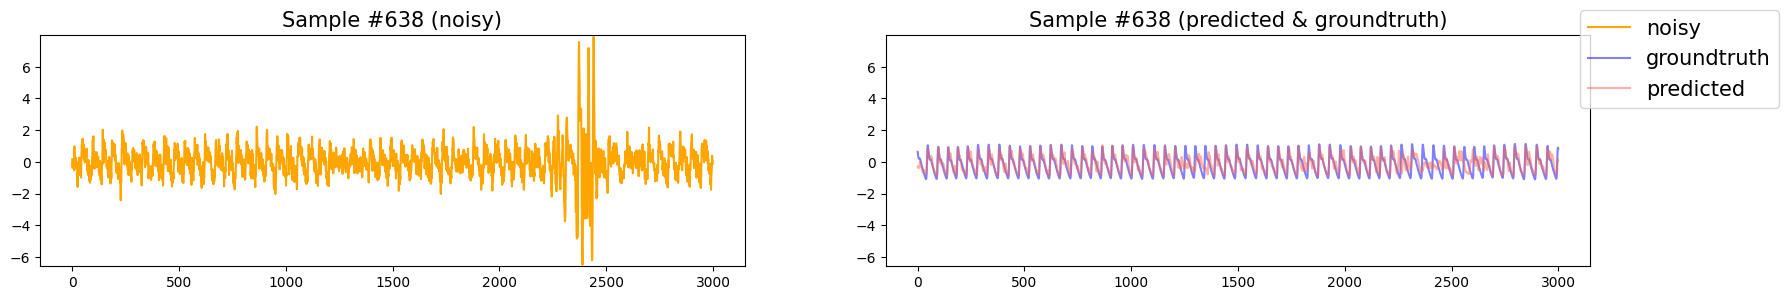

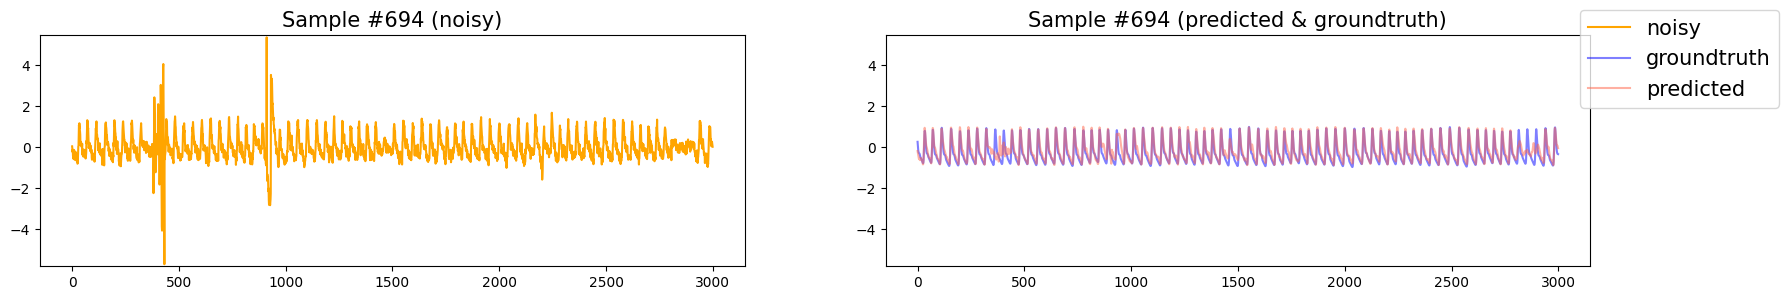

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 1: Train  1.2112378757827136


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: Test  1.0297079803669347
New Best Model!


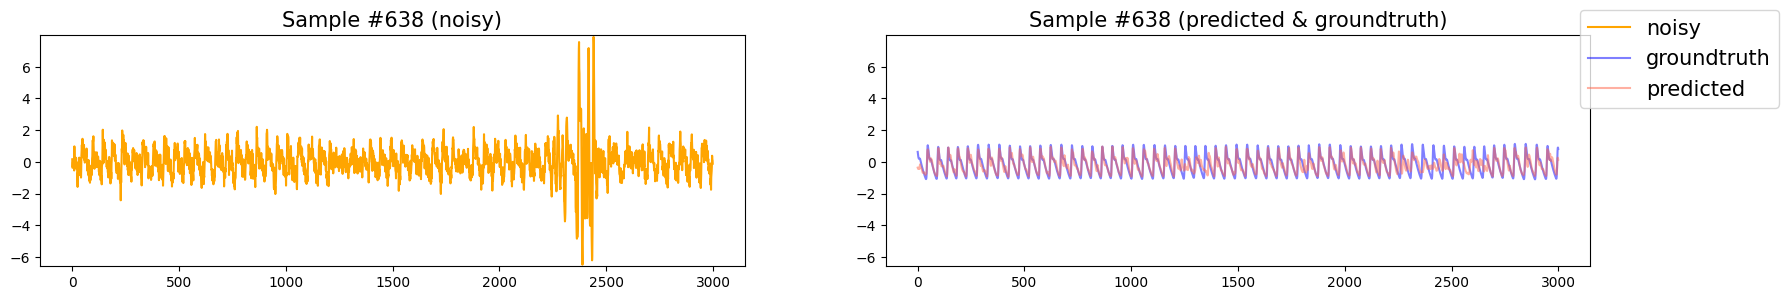

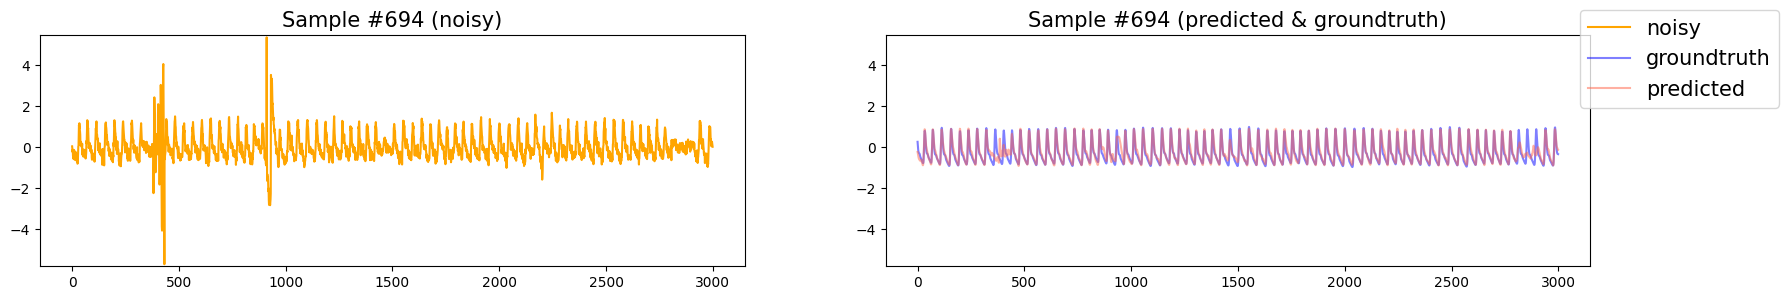

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 2: Train  1.131932028047331


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2: Test  0.9826983730349921
New Best Model!


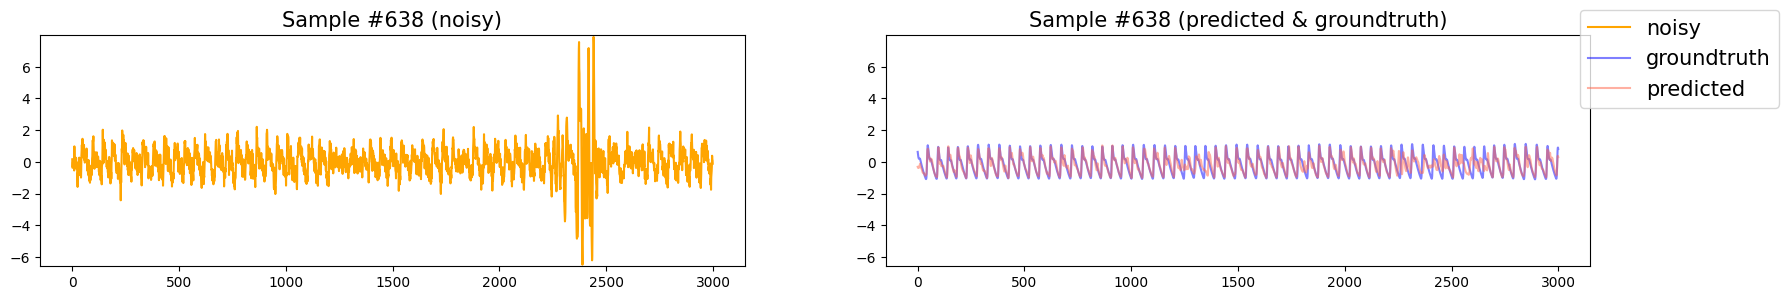

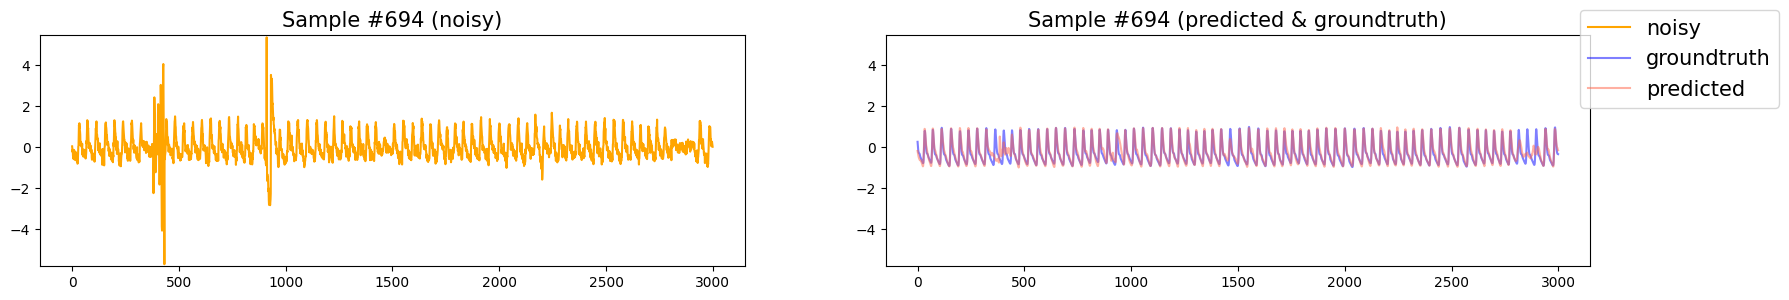

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 3: Train  1.090743445526674


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3: Test  0.9686965330512123
New Best Model!


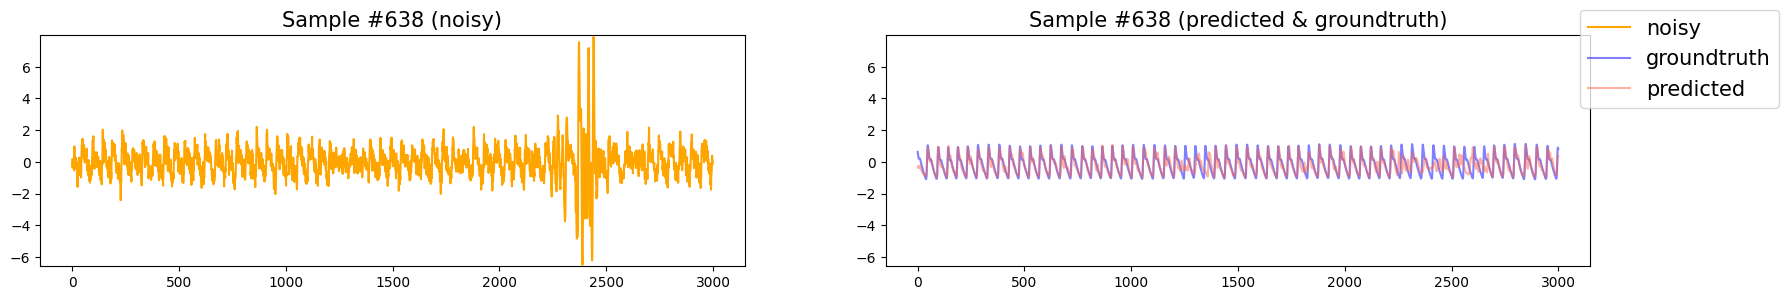

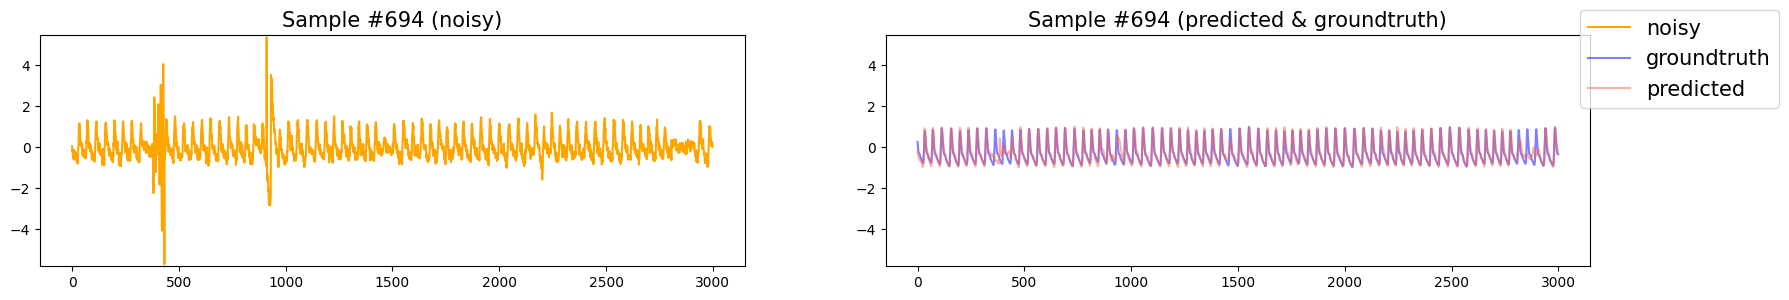

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 4: Train  1.0689153933263087


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4: Test  0.9596055556187587
New Best Model!


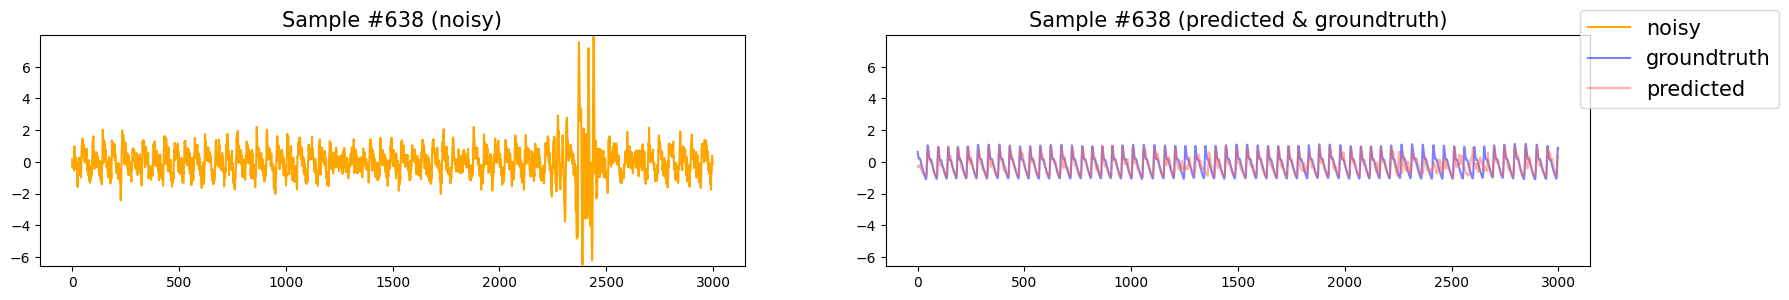

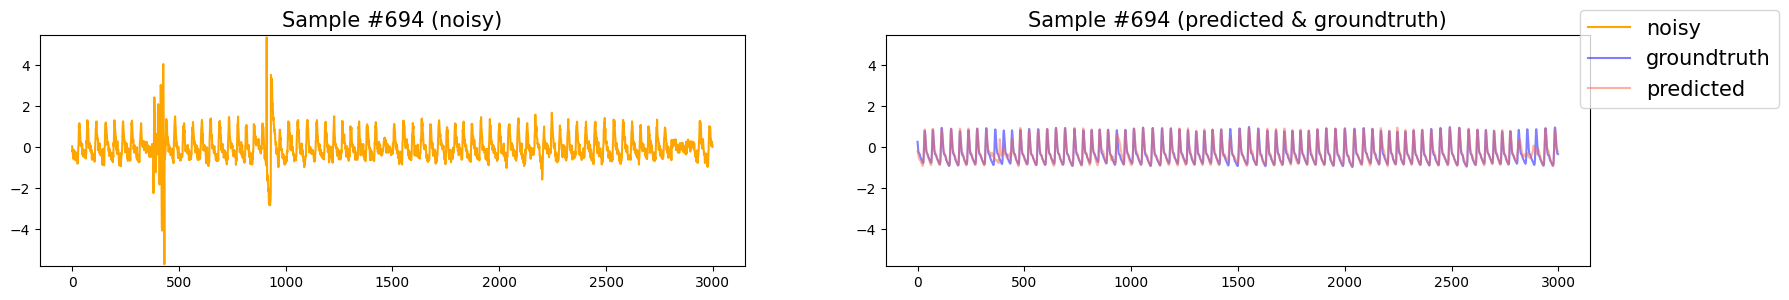

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 5: Train  1.0412032637903044


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5: Test  0.9640971580437855


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 6: Train  1.0247216106771113


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6: Test  0.9282458503689386
New Best Model!


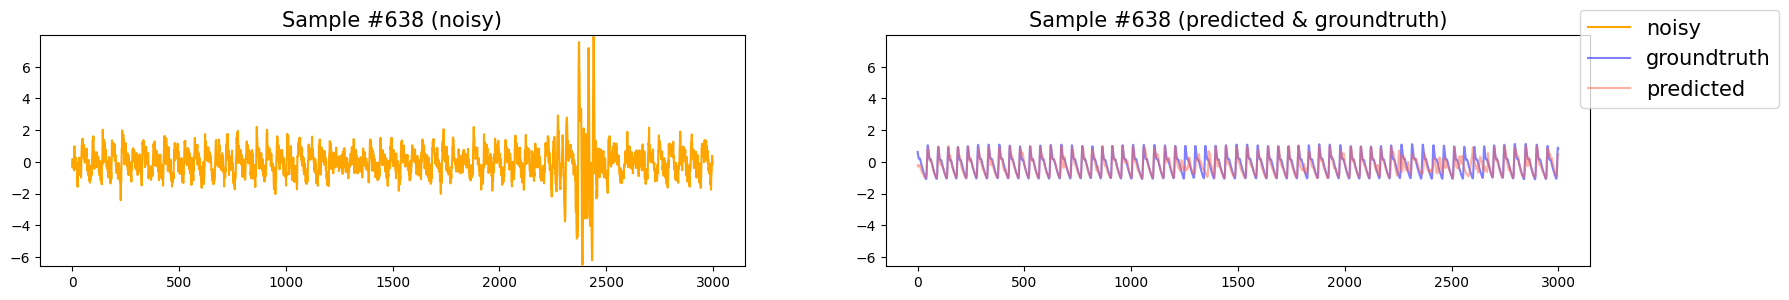

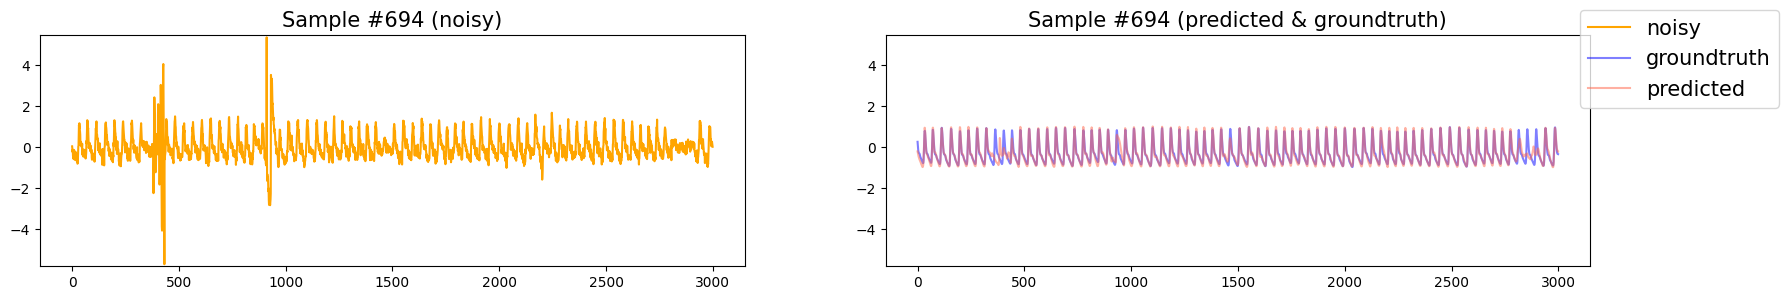

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 7: Train  0.9949658965952168


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7: Test  0.9210269124107023
New Best Model!


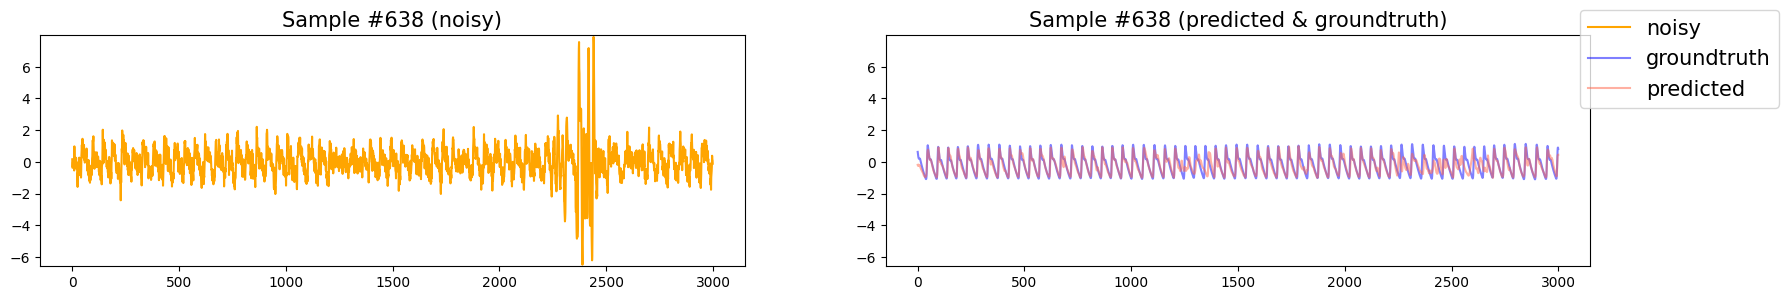

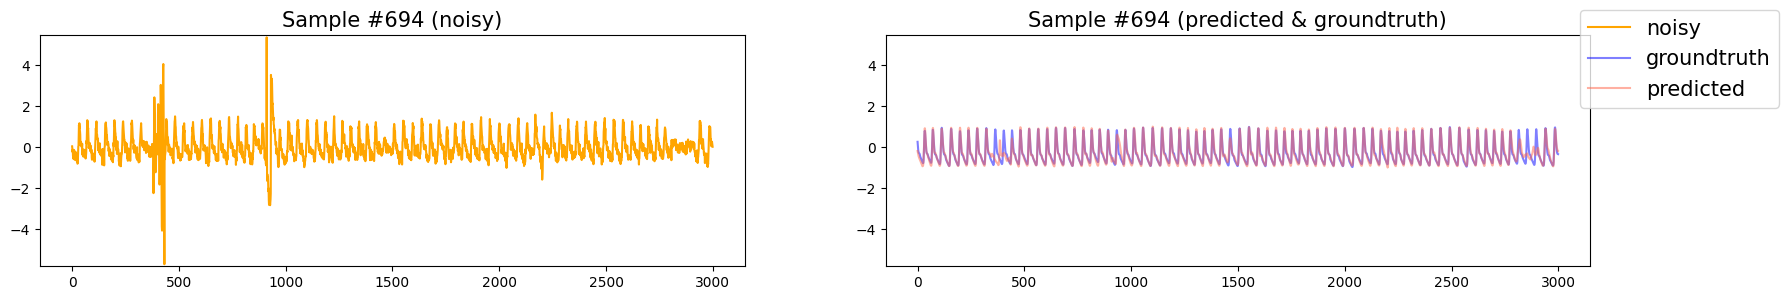

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 8: Train  0.9822055784462012


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8: Test  0.9112047874822026
New Best Model!


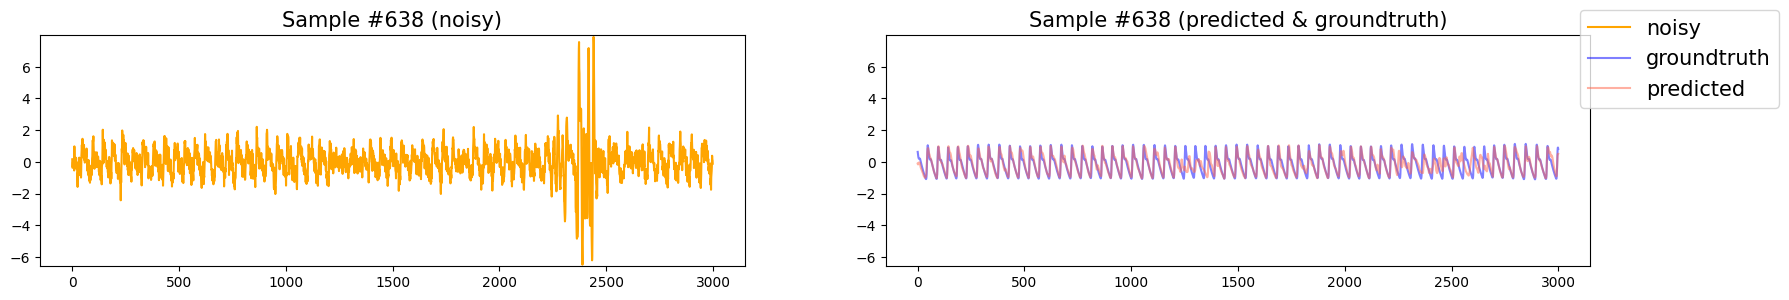

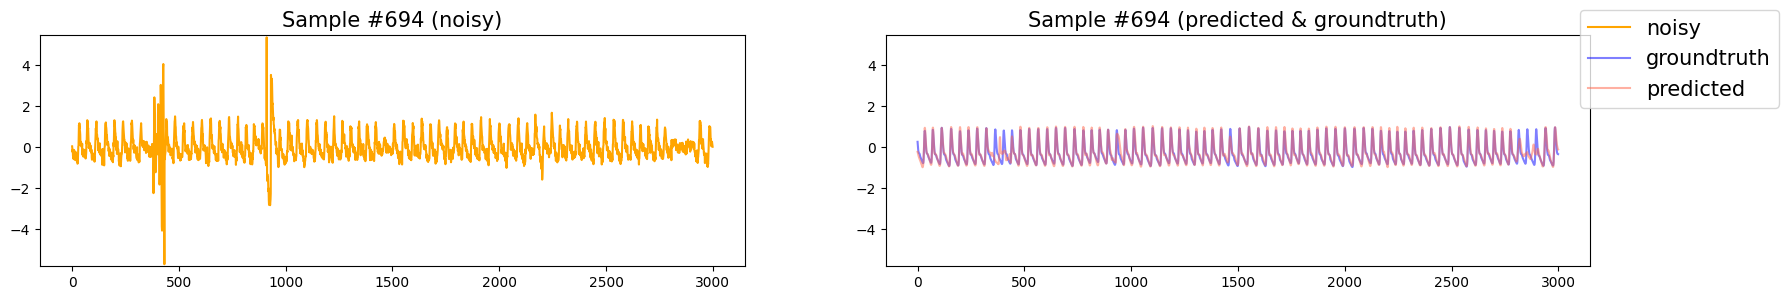

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 9: Train  0.9816673141633697


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9: Test  0.9116024448808315


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 10: Train  0.9665532424648291


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10: Test  0.8799885875355881
New Best Model!


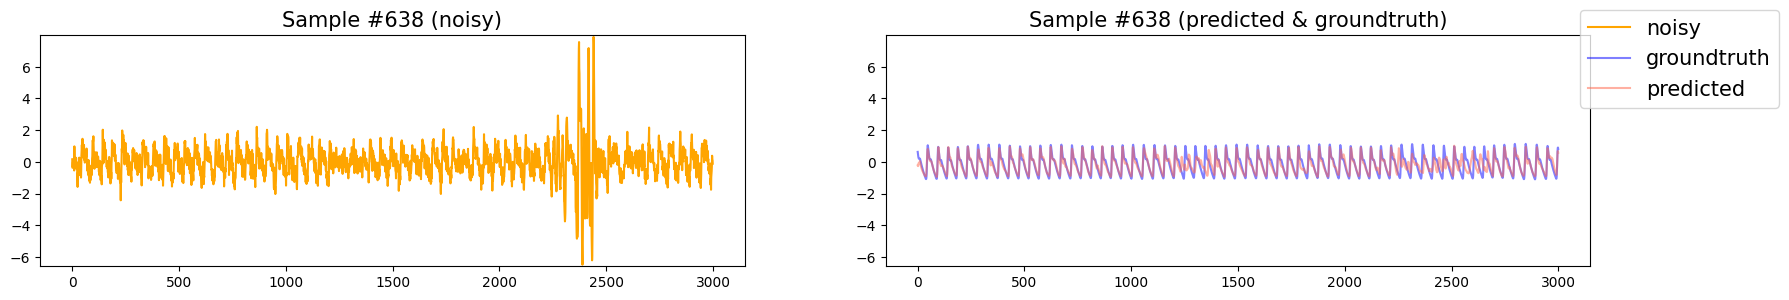

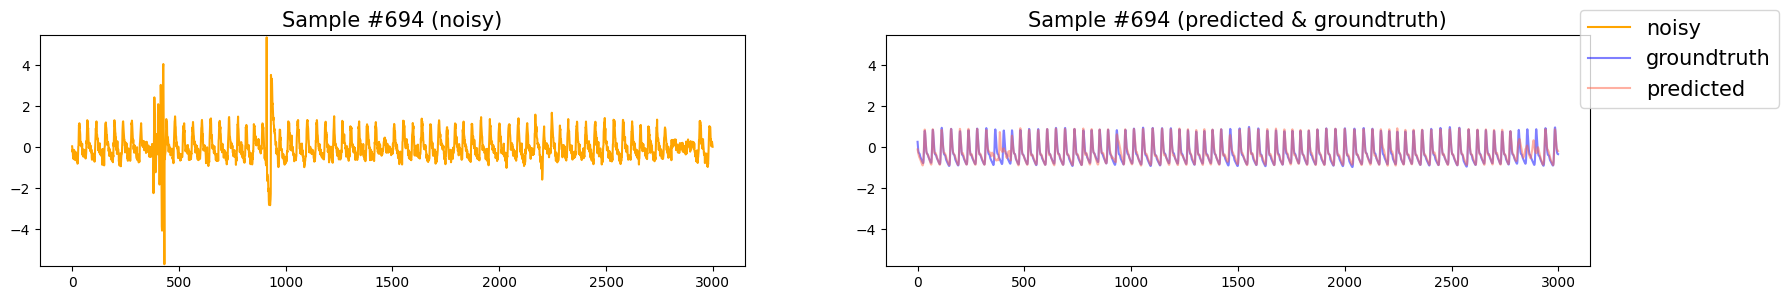

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 11: Train  0.9366338040615363


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11: Test  0.8800546421413928


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 12: Train  0.9332582218867831


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12: Test  0.9245400333826521


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 13: Train  0.9022081019927044


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13: Test  0.8283691801856049
New Best Model!


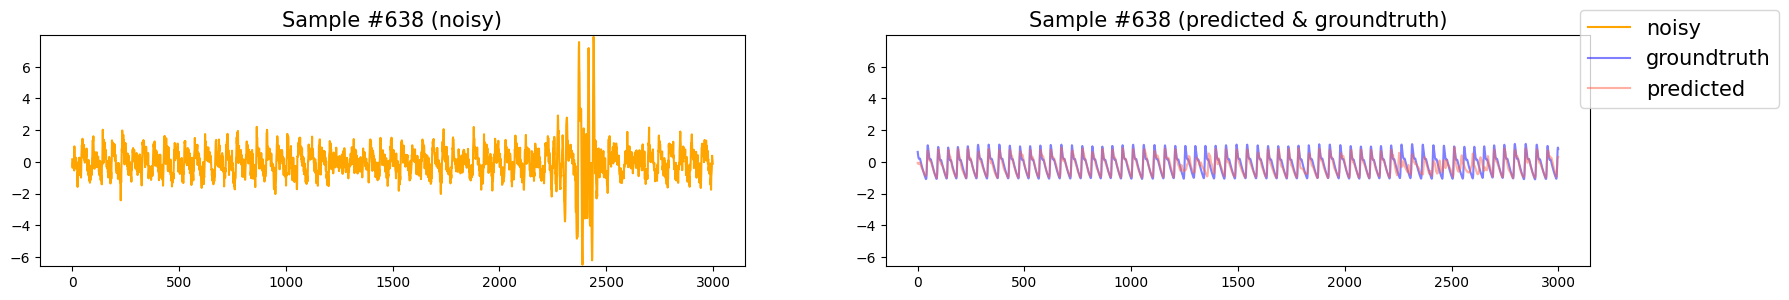

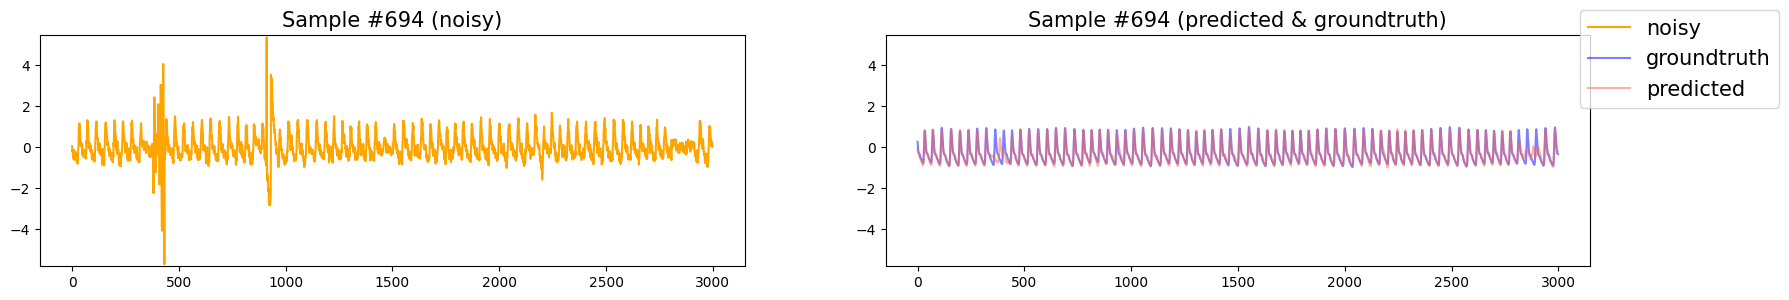

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 14: Train  0.910102327633503


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14: Test  0.8441058144105219


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 15: Train  0.918039543755949


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15: Test  0.8667039349015835


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 16: Train  0.9036991231295527


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16: Test  0.8417862115708072


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 17: Train  0.8847312355528072


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17: Test  0.8368230229985397


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 18: Train  0.8634567898895528


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18: Test  0.8079745379169431
New Best Model!


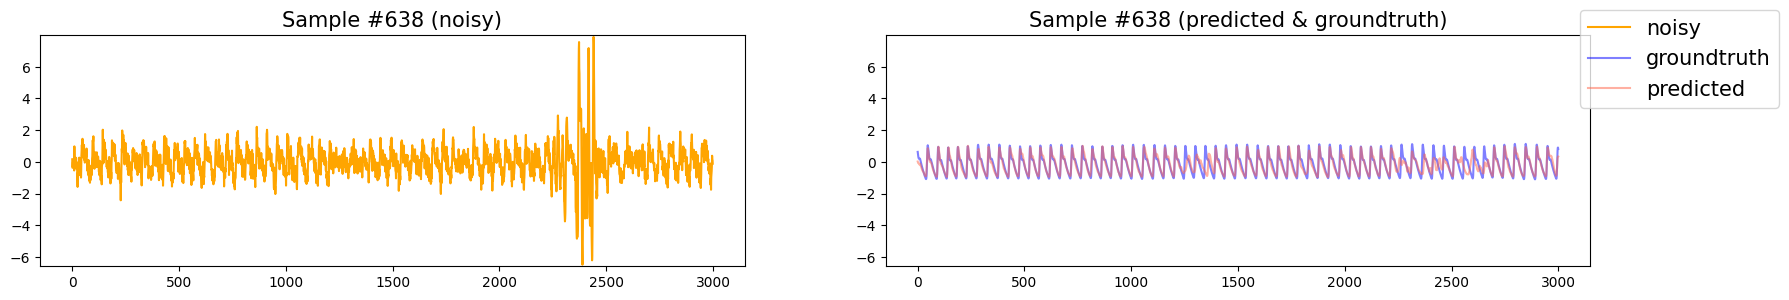

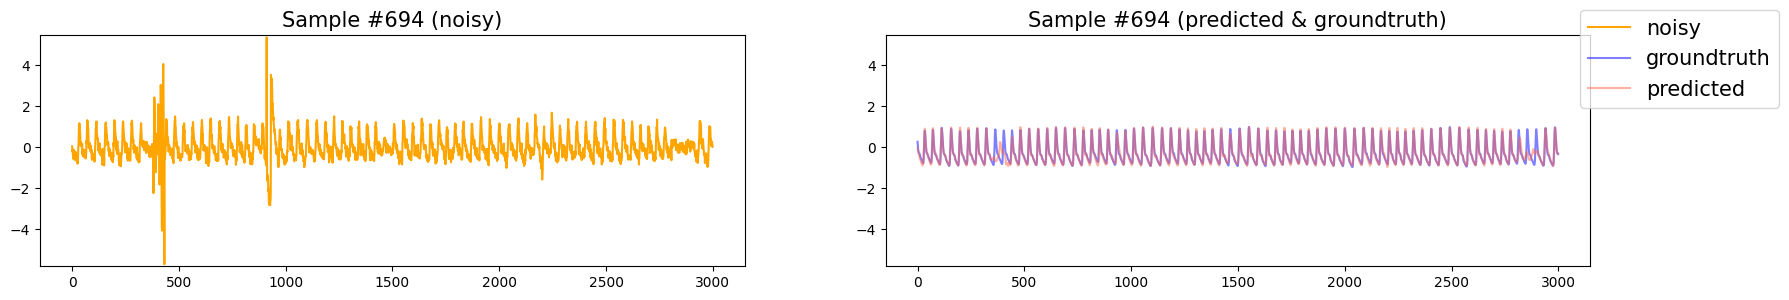

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 19: Train  0.8371722794589667


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19: Test  0.770271995953754
New Best Model!


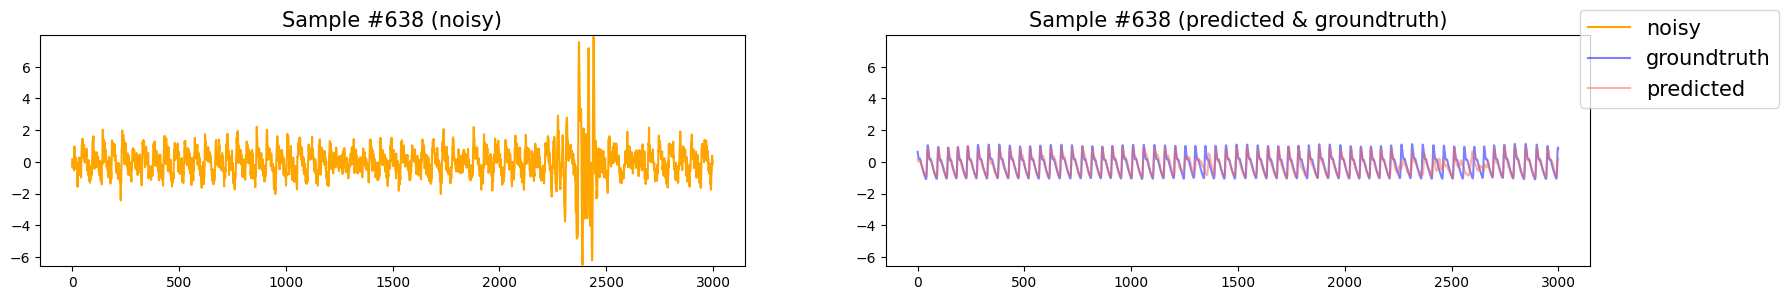

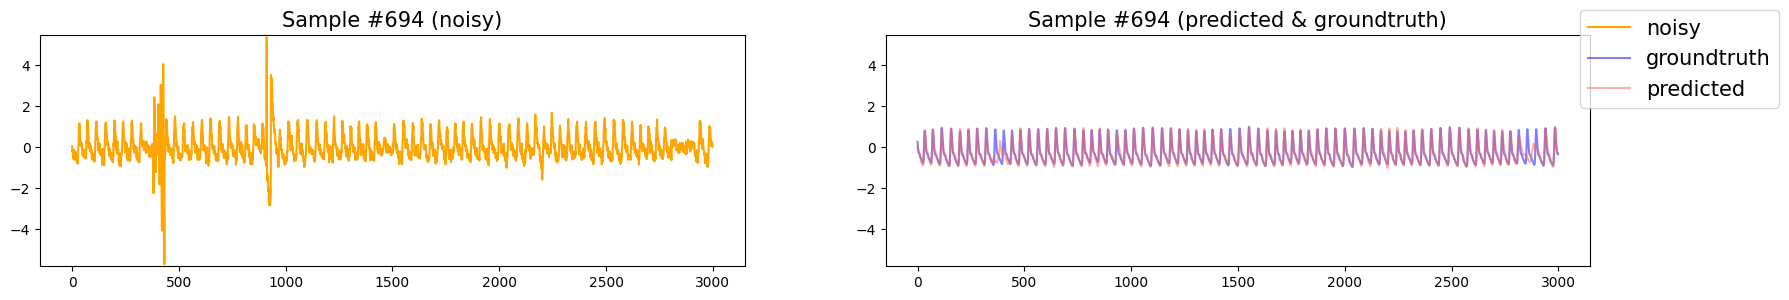

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 20: Train  0.8119469019270018


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20: Test  0.7777836201465236


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 21: Train  0.7963454633530118


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21: Test  0.7427806020837969
New Best Model!


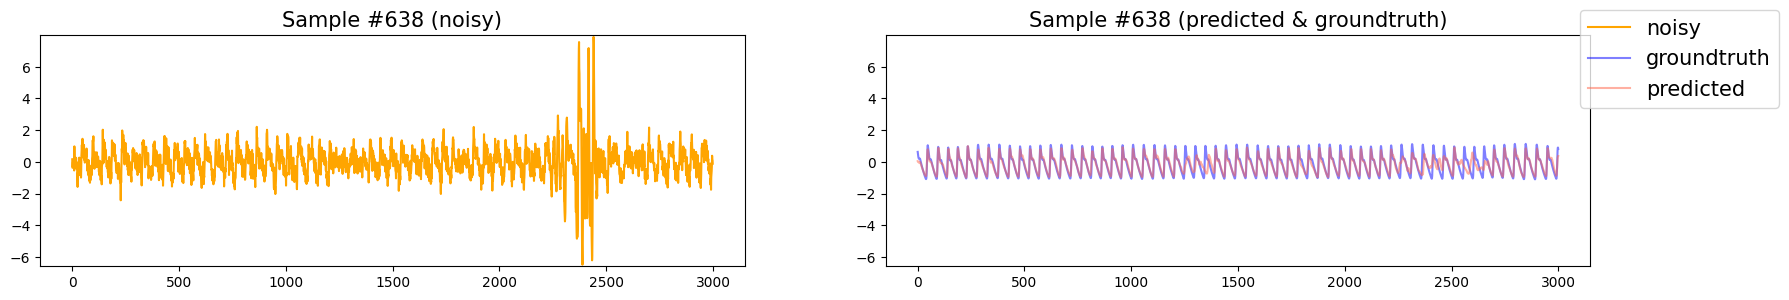

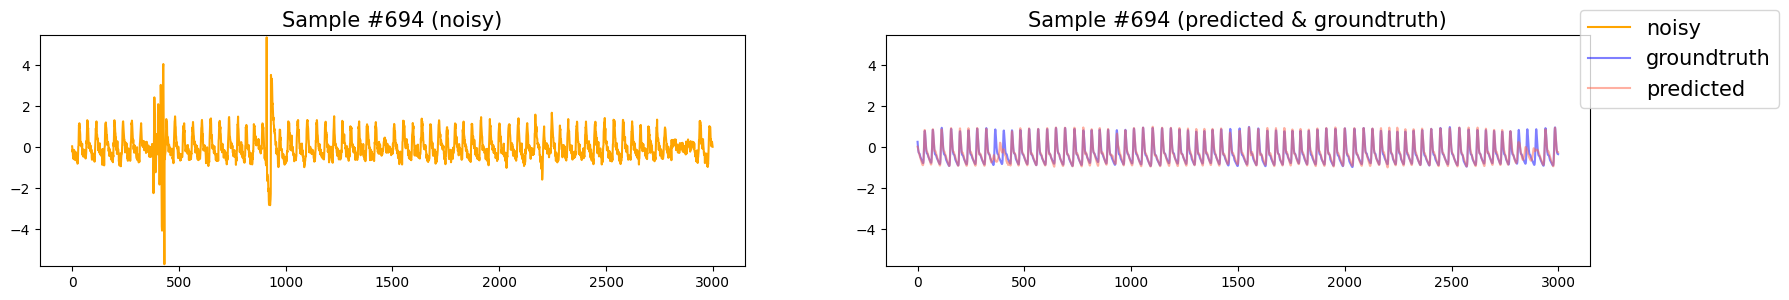

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 22: Train  0.7762923422189111


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22: Test  0.7251100941041929
New Best Model!


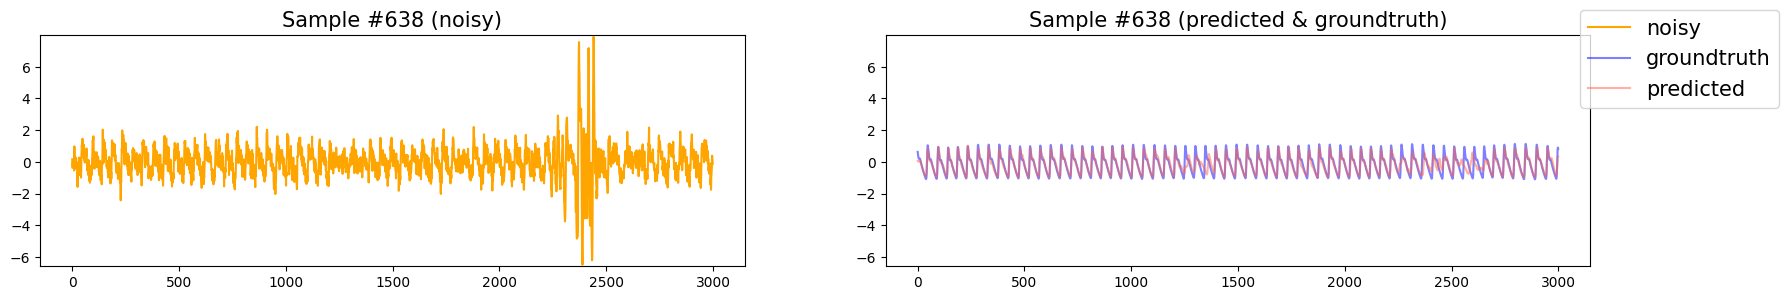

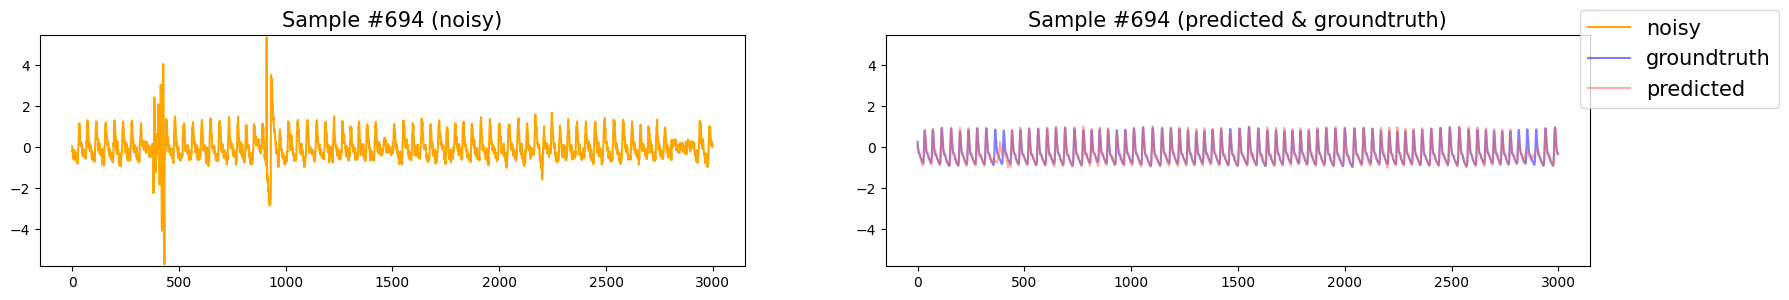

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 23: Train  0.7658448637561109


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23: Test  0.7270479207545255


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 24: Train  0.7427894648053396


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24: Test  0.6926783829663707
New Best Model!


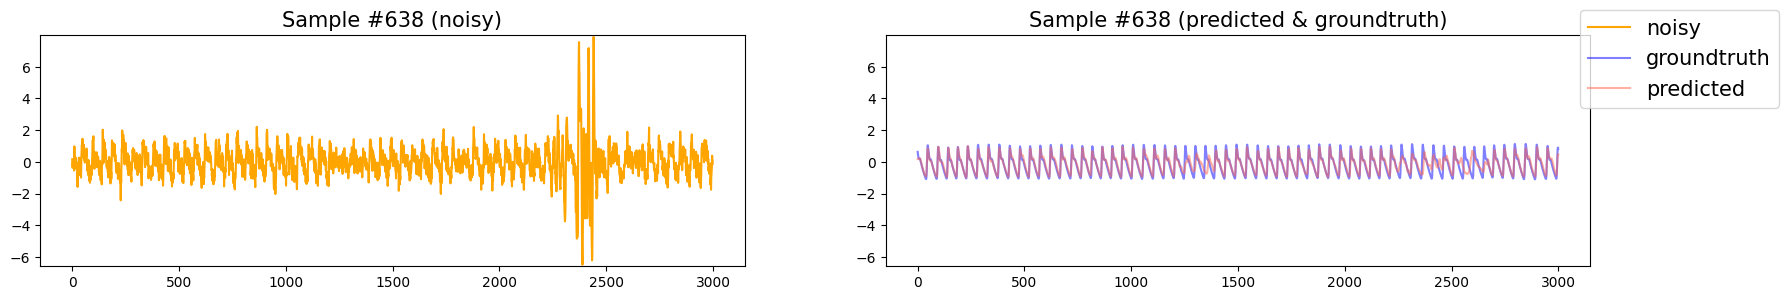

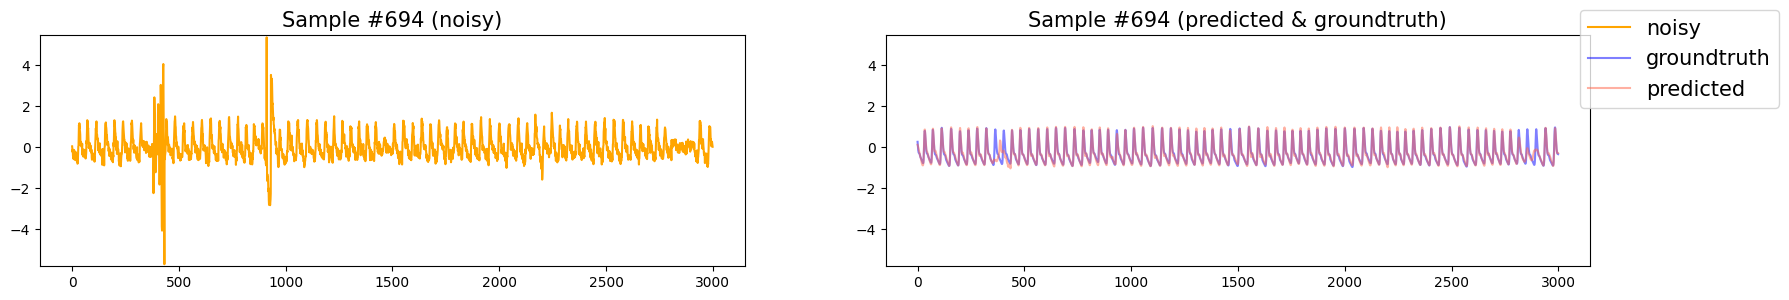

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 25: Train  0.729510161435024


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25: Test  0.7022921706722901


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 26: Train  0.7331344806230985


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26: Test  0.6953677223846976


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 27: Train  0.7093511533512612


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27: Test  0.6813200728028221
New Best Model!


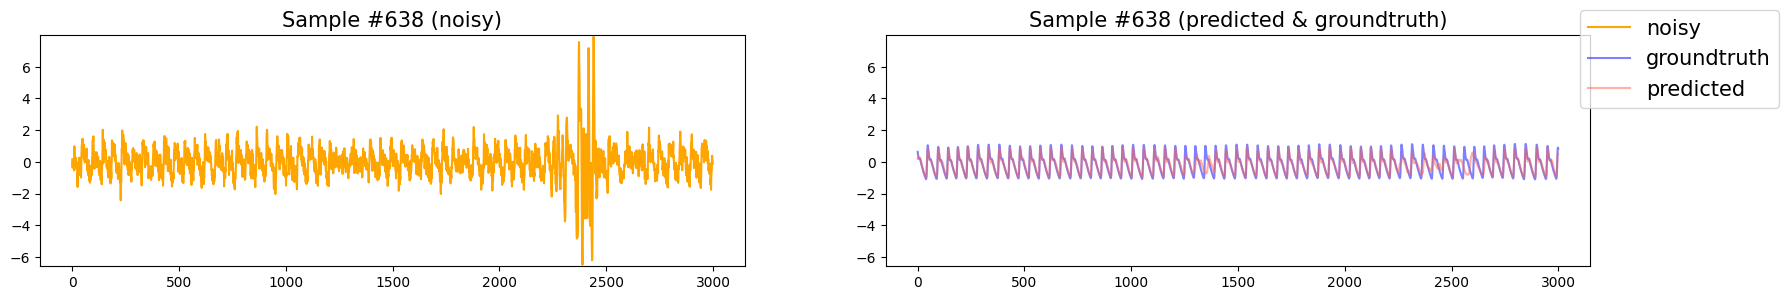

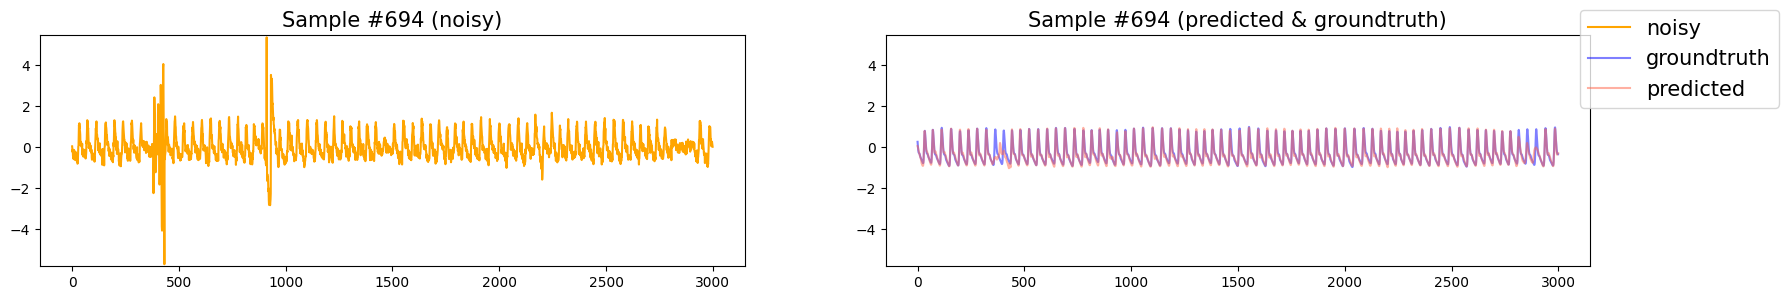

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 28: Train  0.6967135227082101


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28: Test  0.6654220539911658
New Best Model!


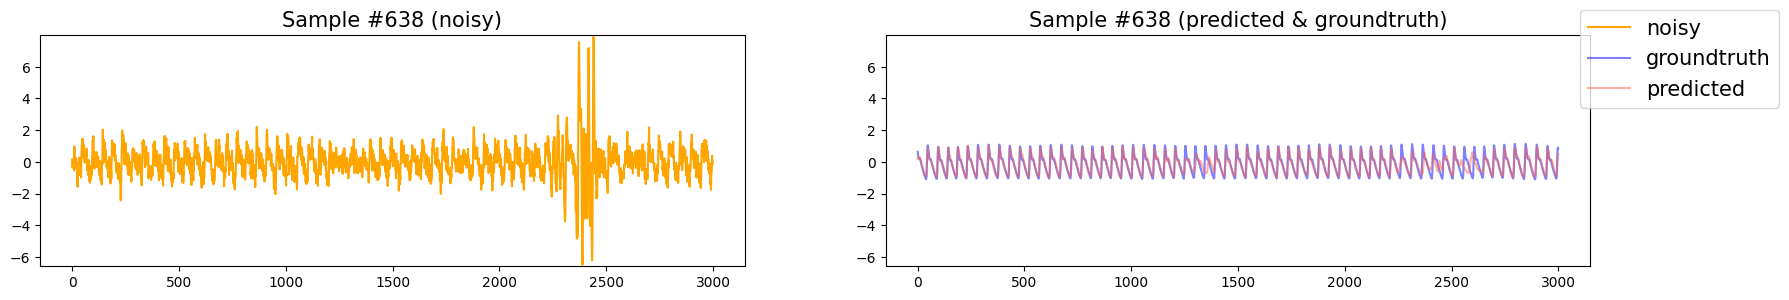

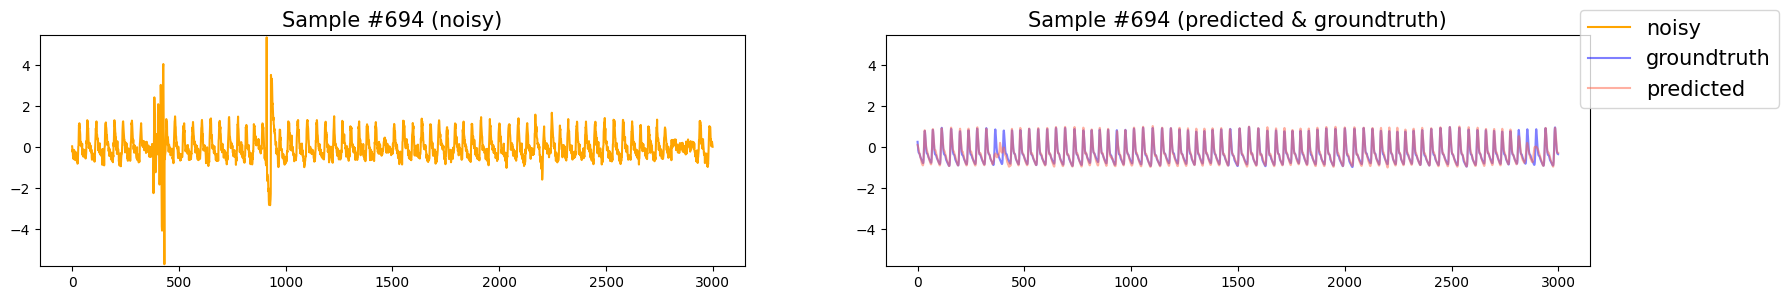

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 29: Train  0.6875411465740653


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29: Test  0.6620278912307942
New Best Model!


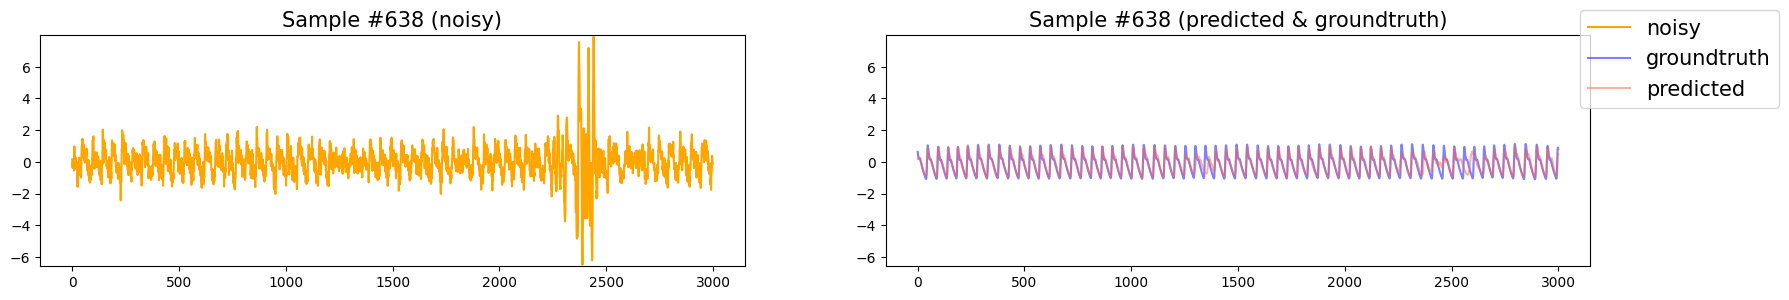

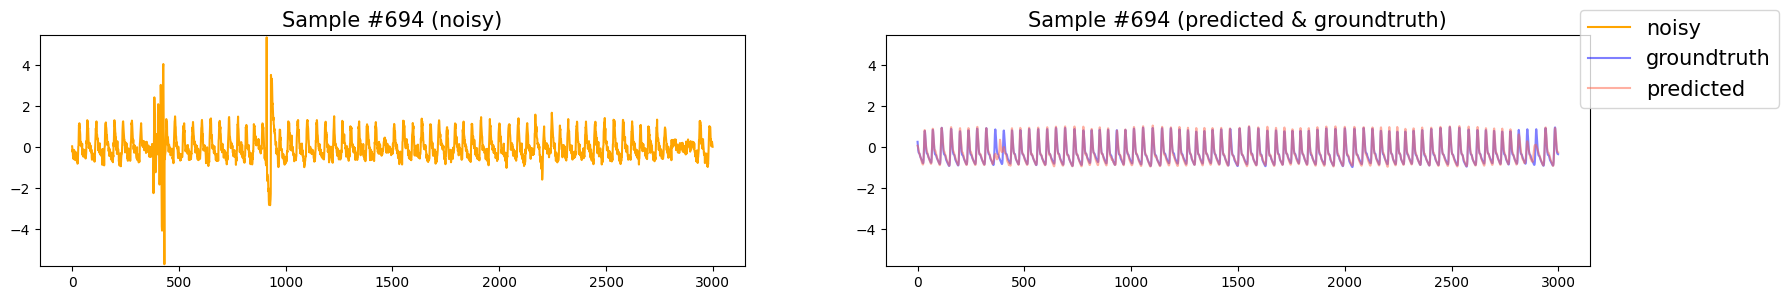

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 30: Train  0.6691872561745217


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30: Test  0.6443091393572039
New Best Model!


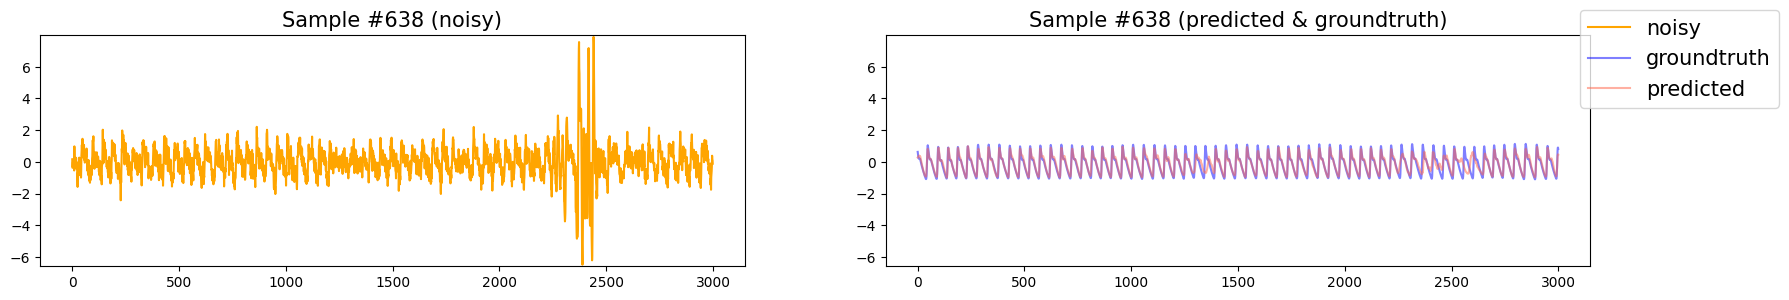

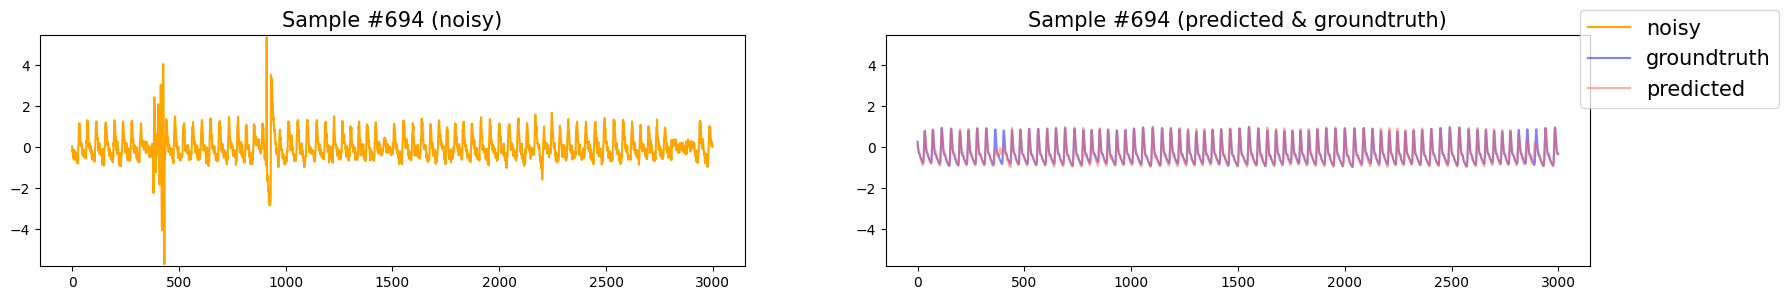

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 31: Train  0.6613501030571607


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31: Test  0.6439568099722398
New Best Model!


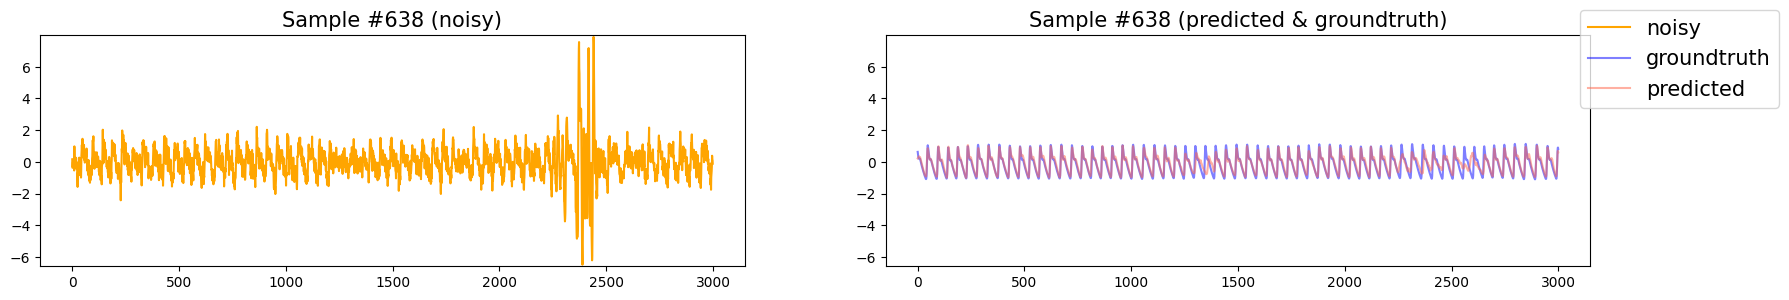

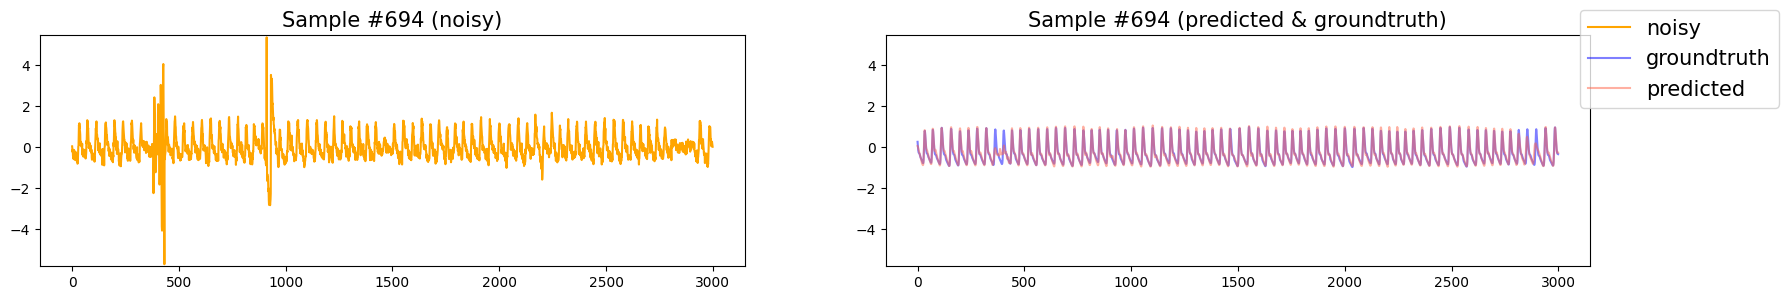

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 32: Train  0.654955983349068


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32: Test  0.6364172354208685
New Best Model!


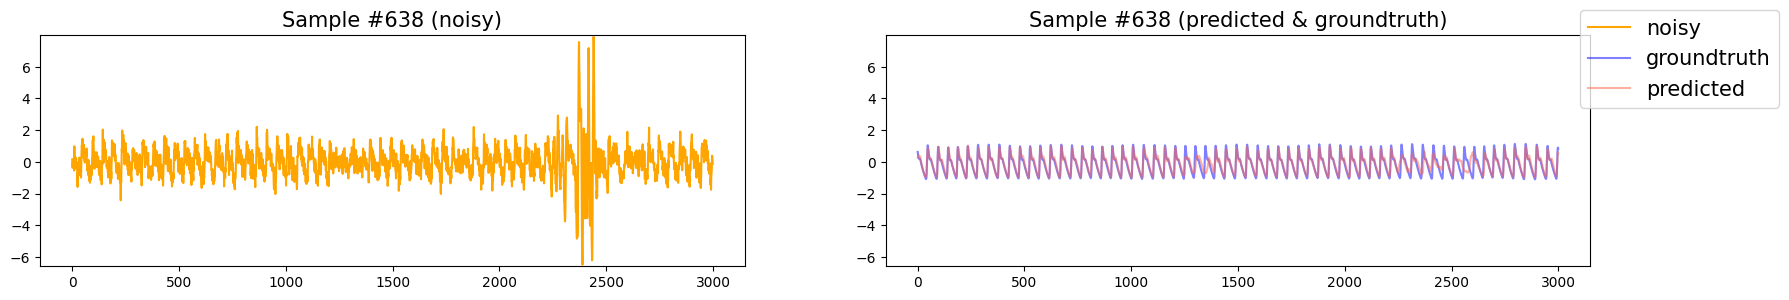

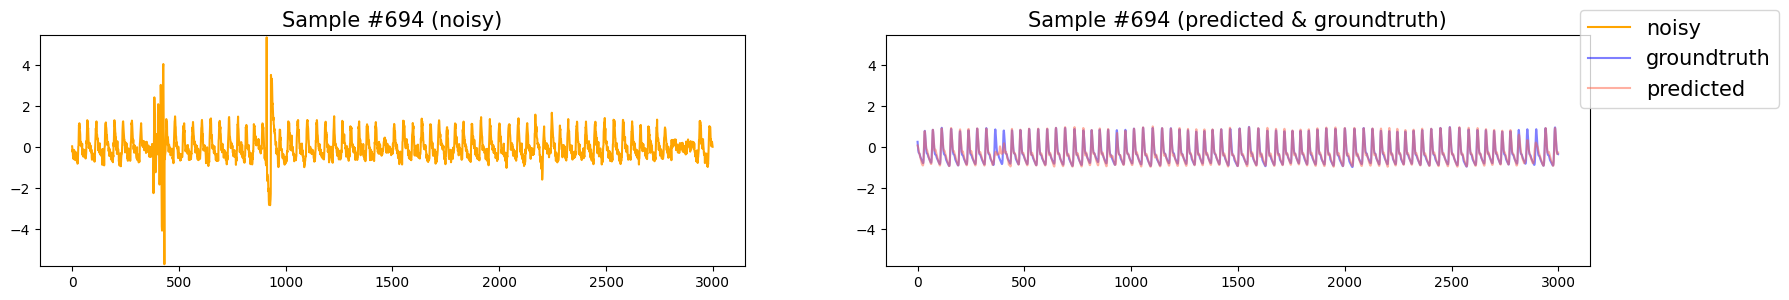

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 33: Train  0.6452000739061664


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33: Test  0.6302342583647872
New Best Model!


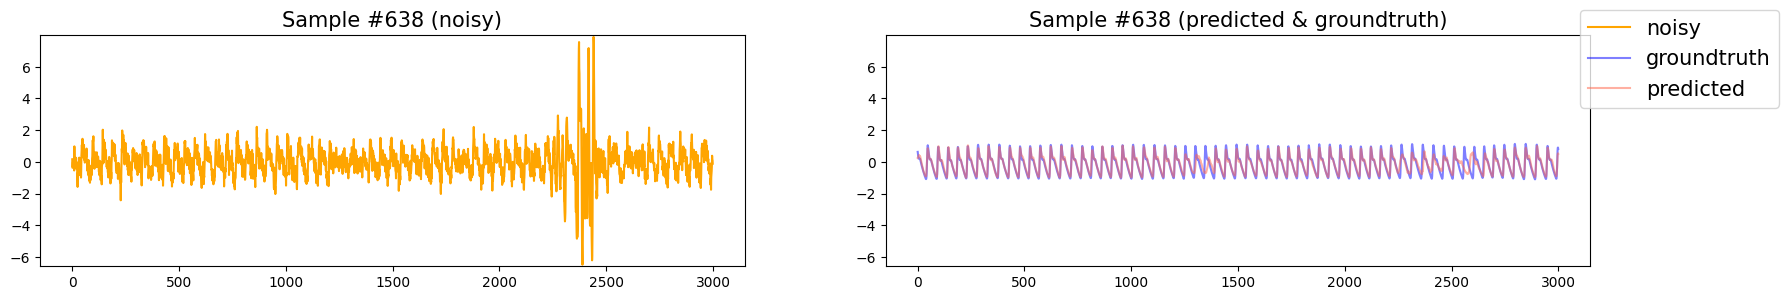

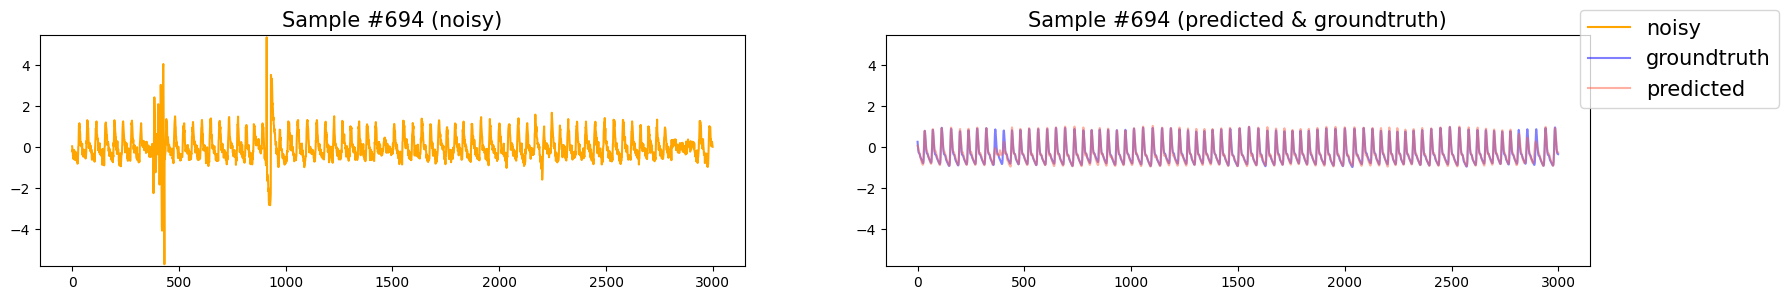

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 34: Train  0.6374666467192035


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34: Test  0.619920468963353
New Best Model!


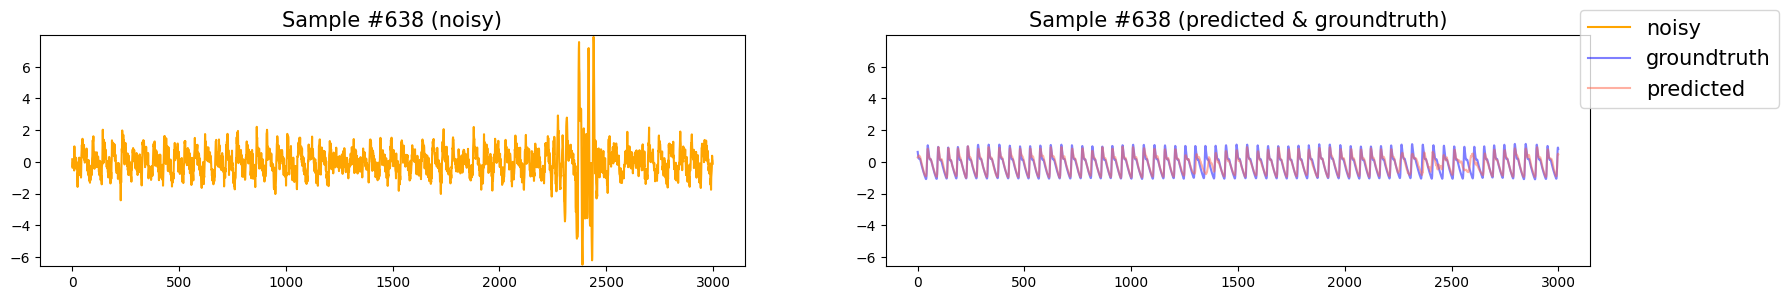

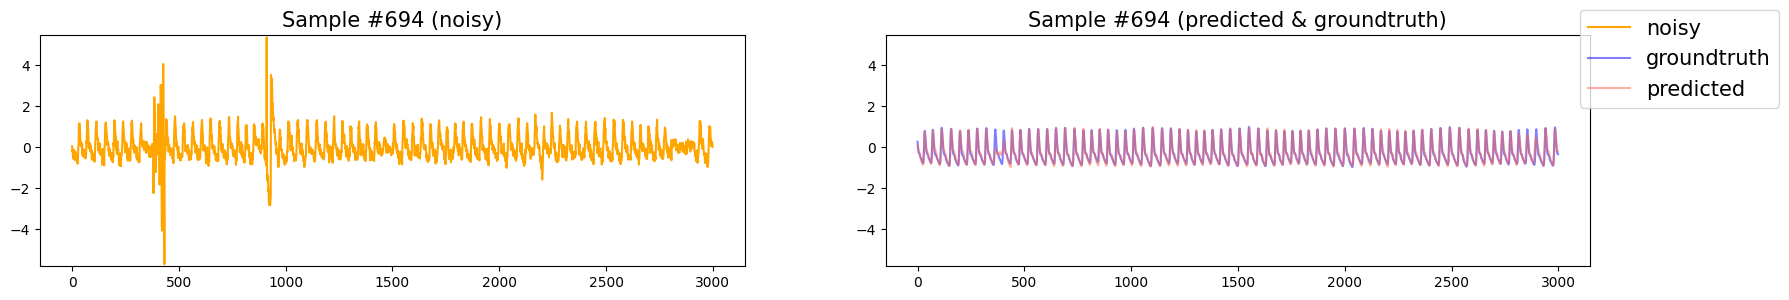

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 35: Train  0.6267290557010956


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35: Test  0.6194365852701981
New Best Model!


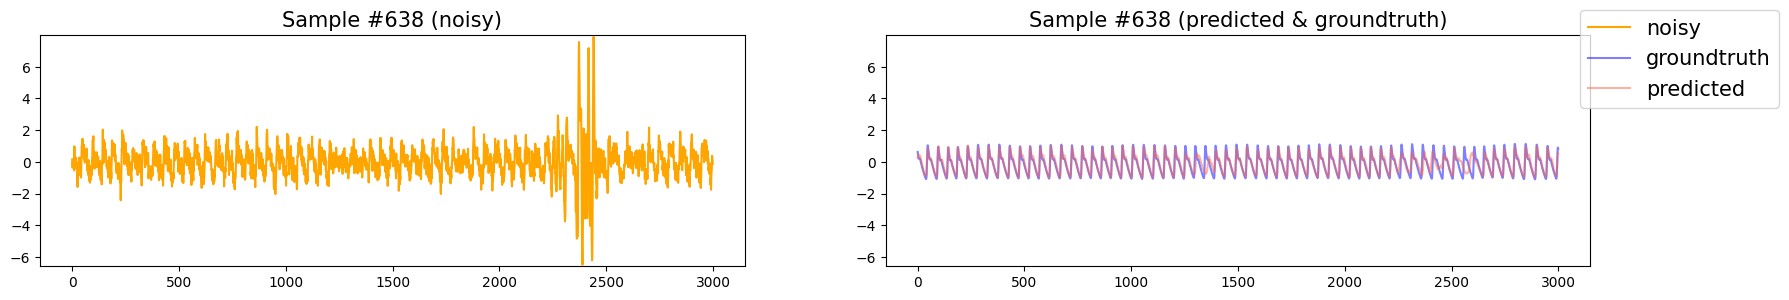

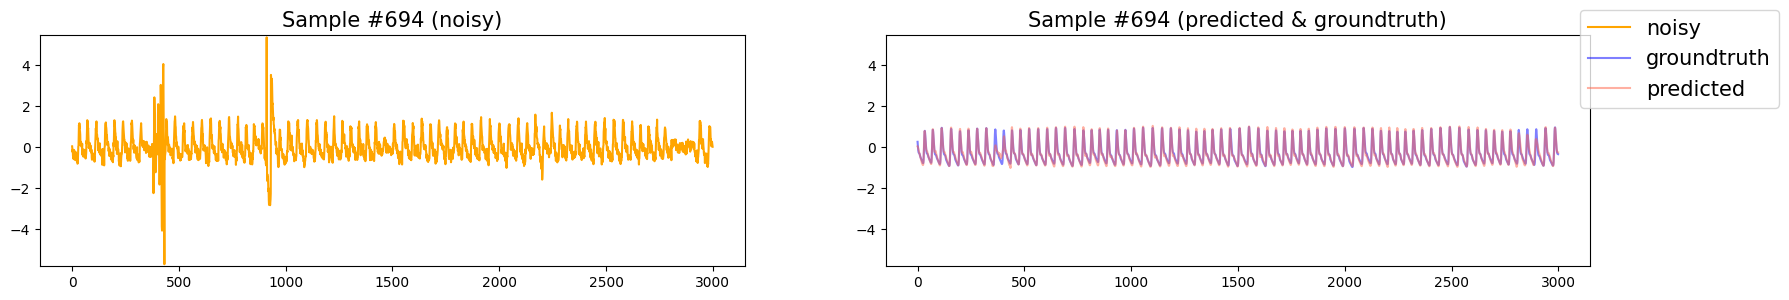

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 36: Train  0.6252607170790668


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36: Test  0.6079614025301638
New Best Model!


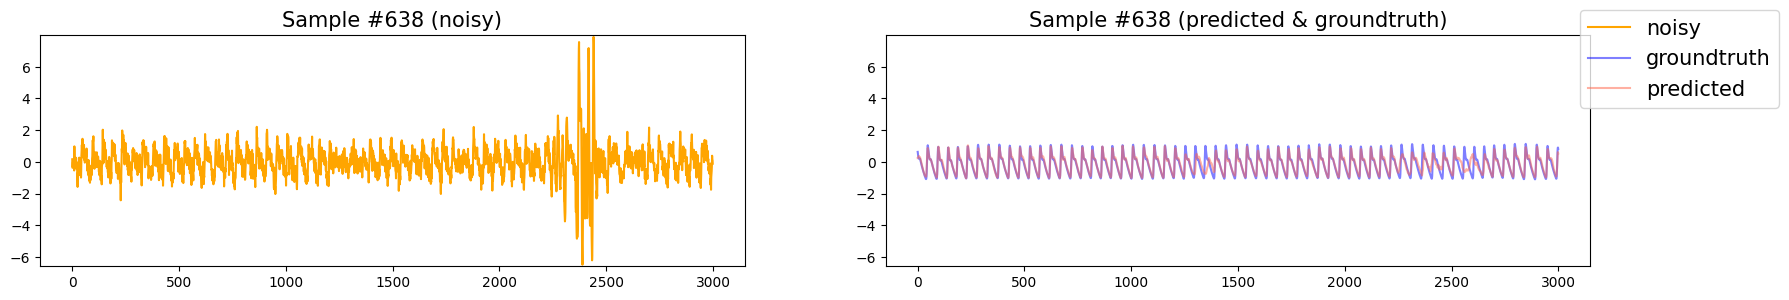

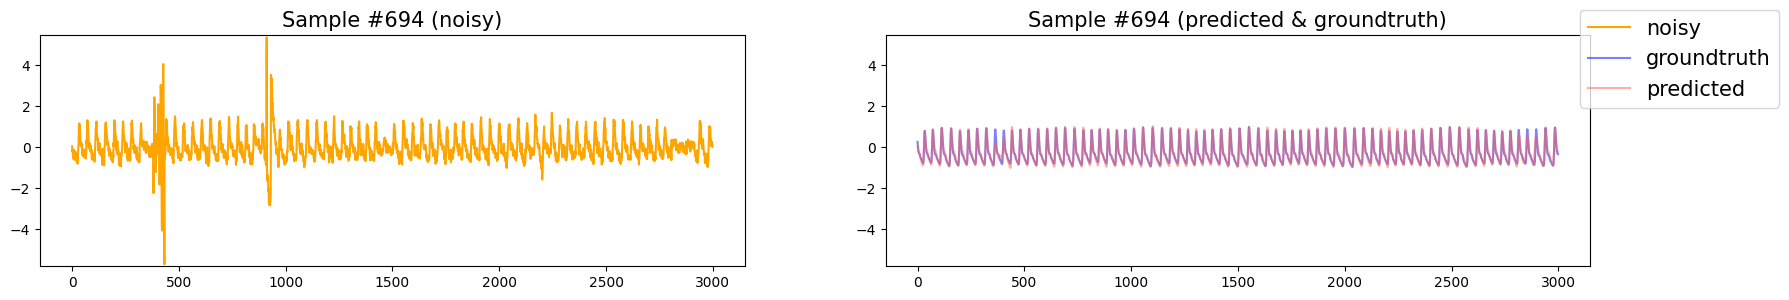

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 37: Train  0.6161343969954426


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37: Test  0.6145413554875196


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 38: Train  0.6173088611388693


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38: Test  0.6154488926440214


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 39: Train  0.6072817747035244


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39: Test  0.598828227646583
New Best Model!


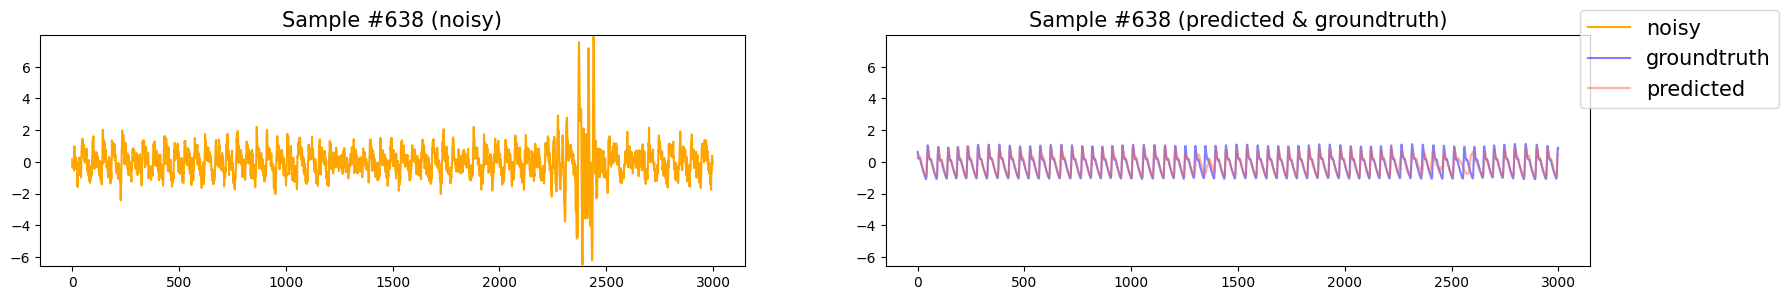

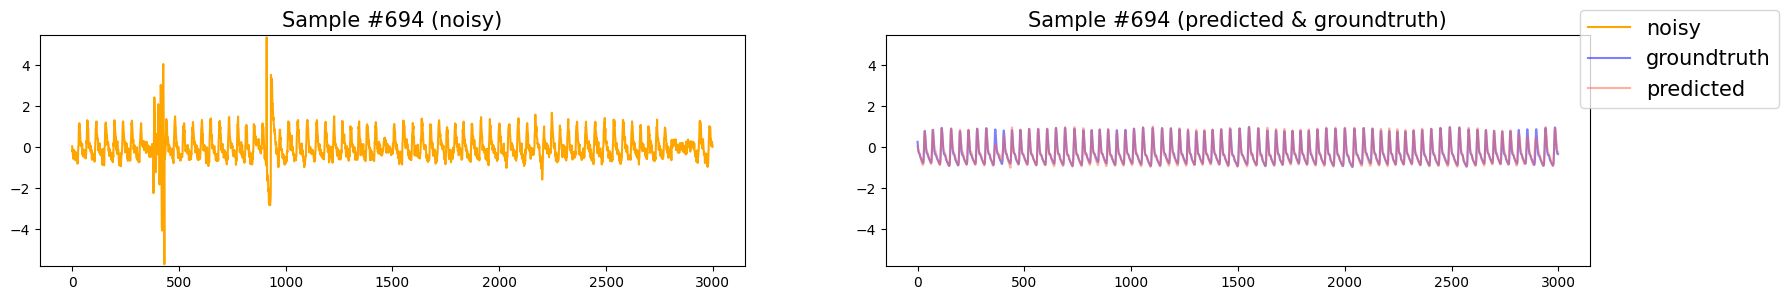

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 40: Train  0.6001272882734027


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40: Test  0.6025036256925195


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 41: Train  0.5975995907790994


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41: Test  0.5926244897125041
New Best Model!


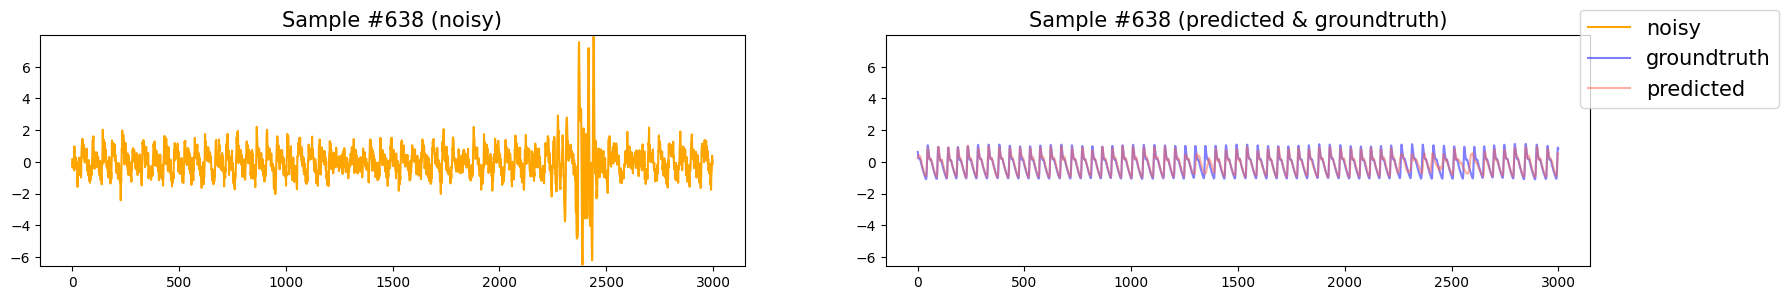

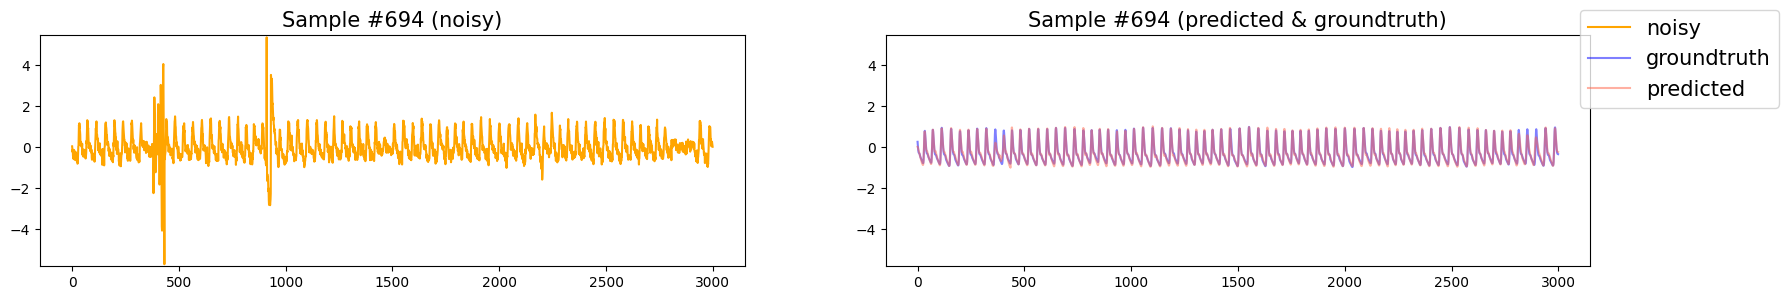

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 42: Train  0.5923665380178479


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42: Test  0.5926001420063255
New Best Model!


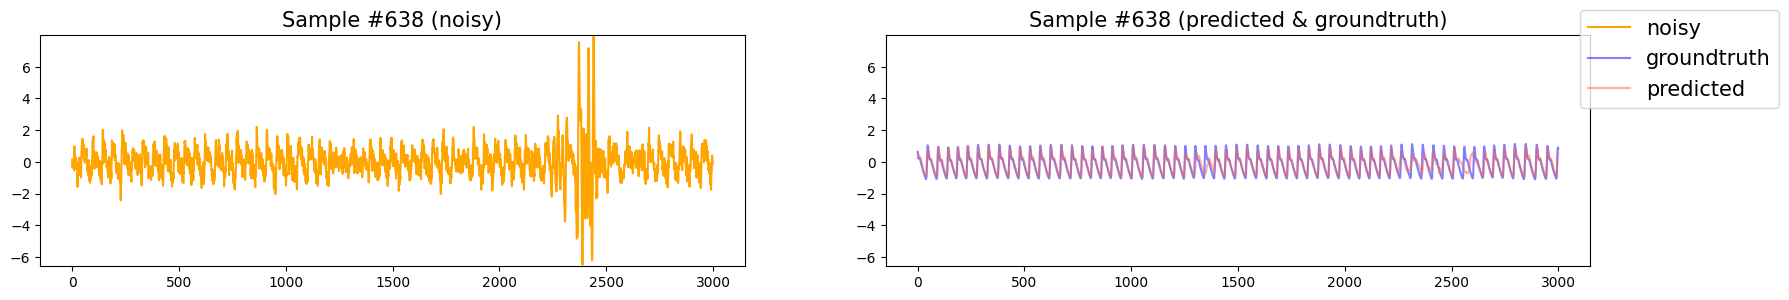

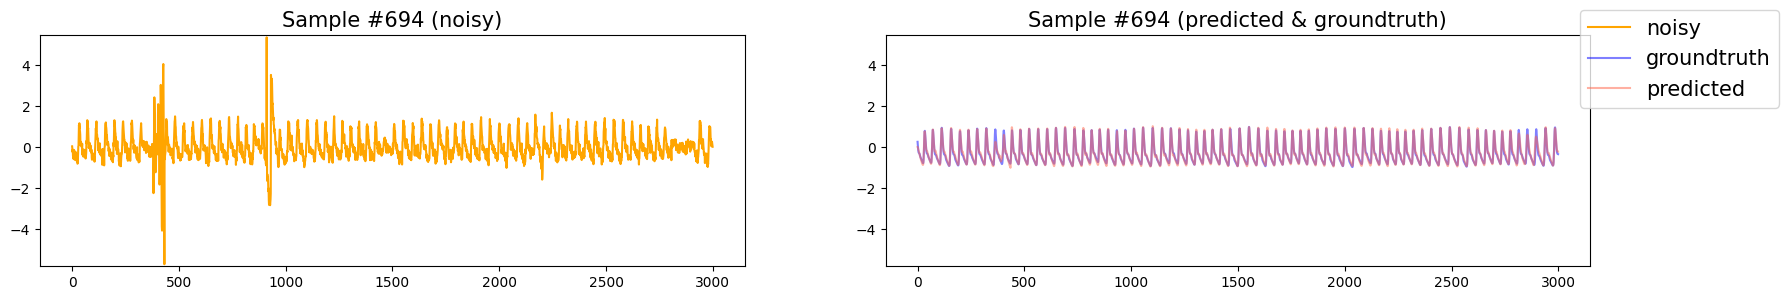

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 43: Train  0.5904104112643088


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43: Test  0.5919153416051274
New Best Model!


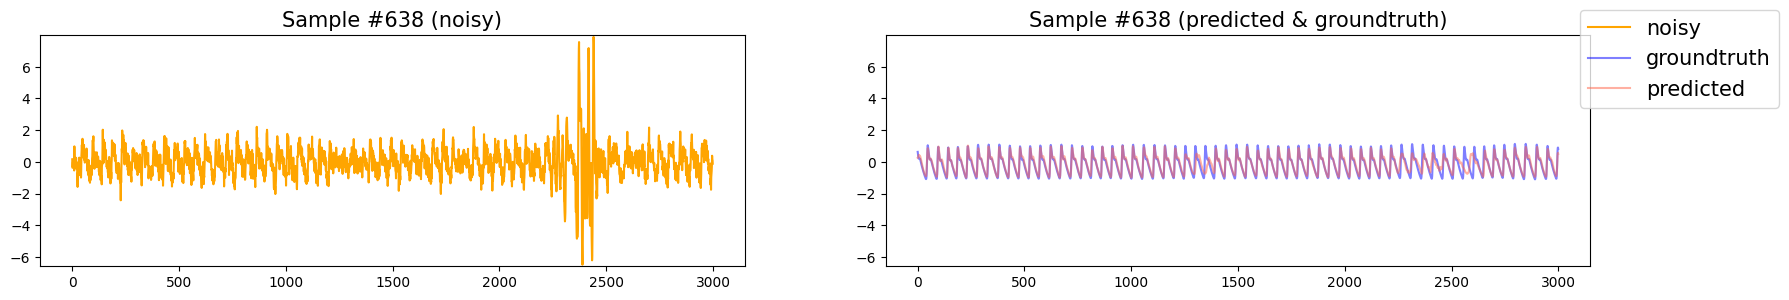

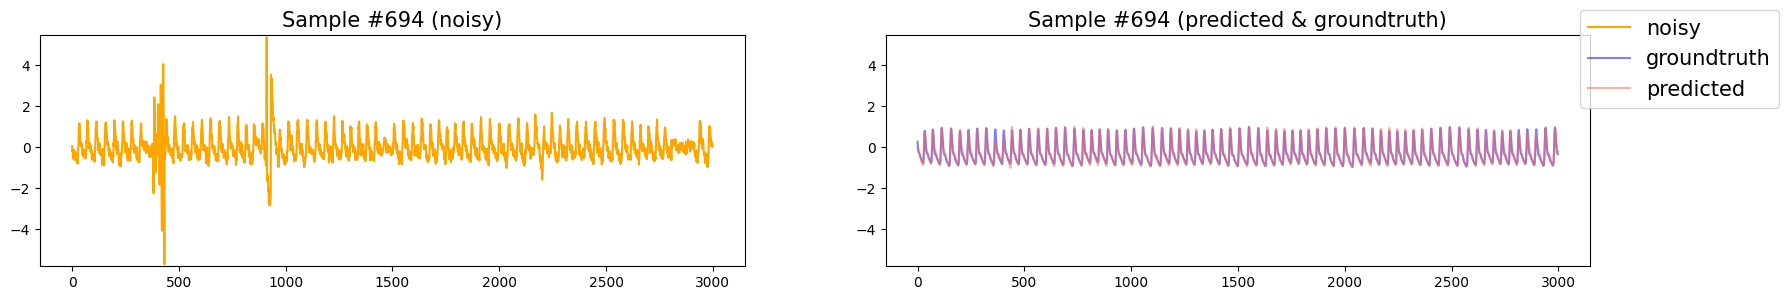

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 44: Train  0.5880343651097835


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44: Test  0.5907300621007396
New Best Model!


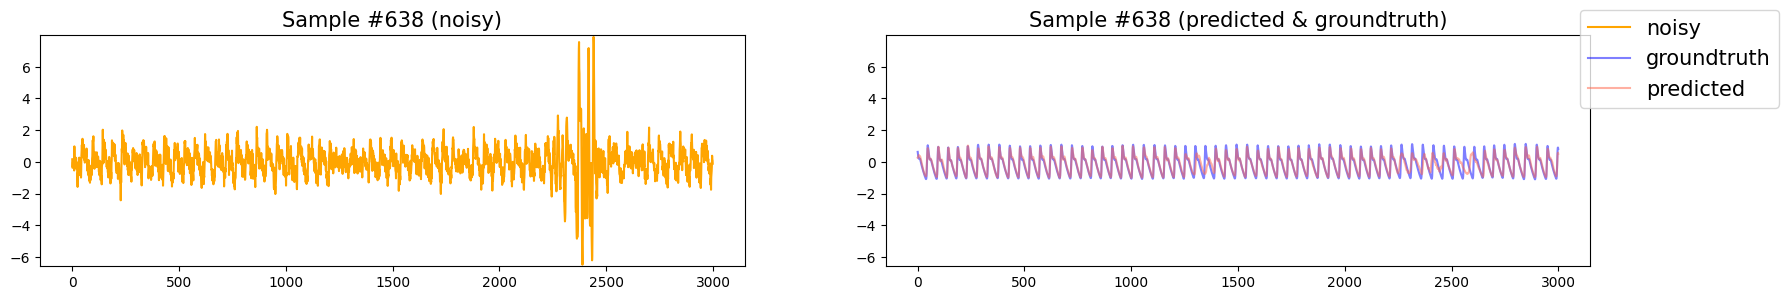

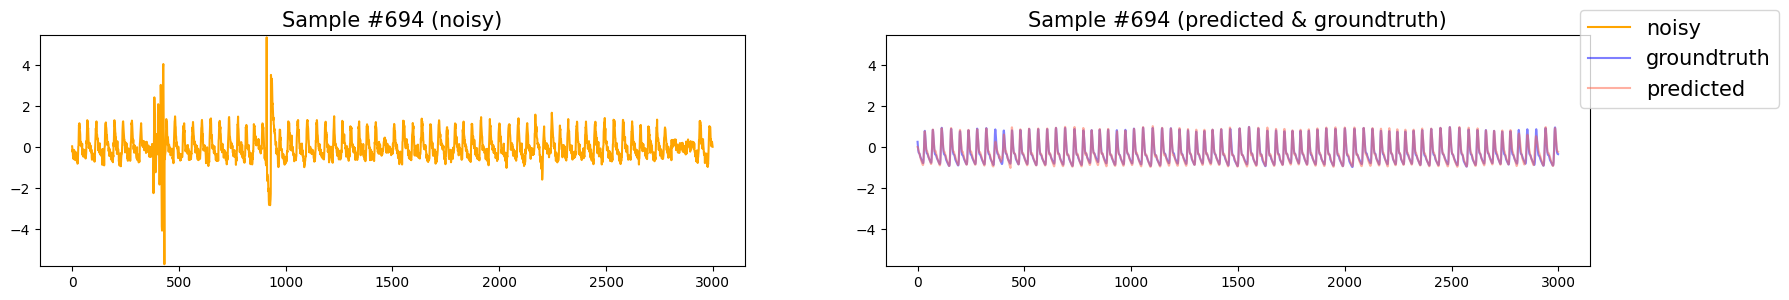

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 45: Train  0.5868997859243695


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45: Test  0.5897813819151009
New Best Model!


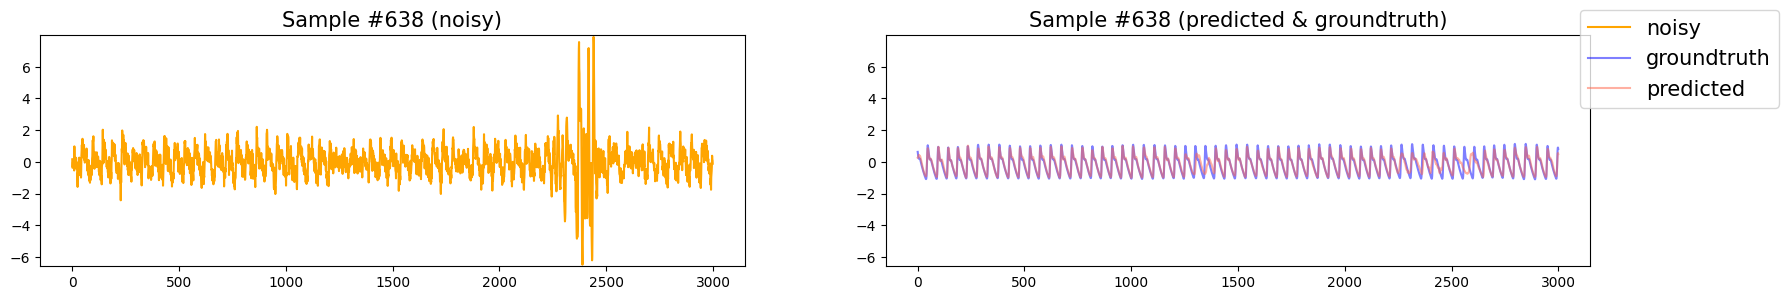

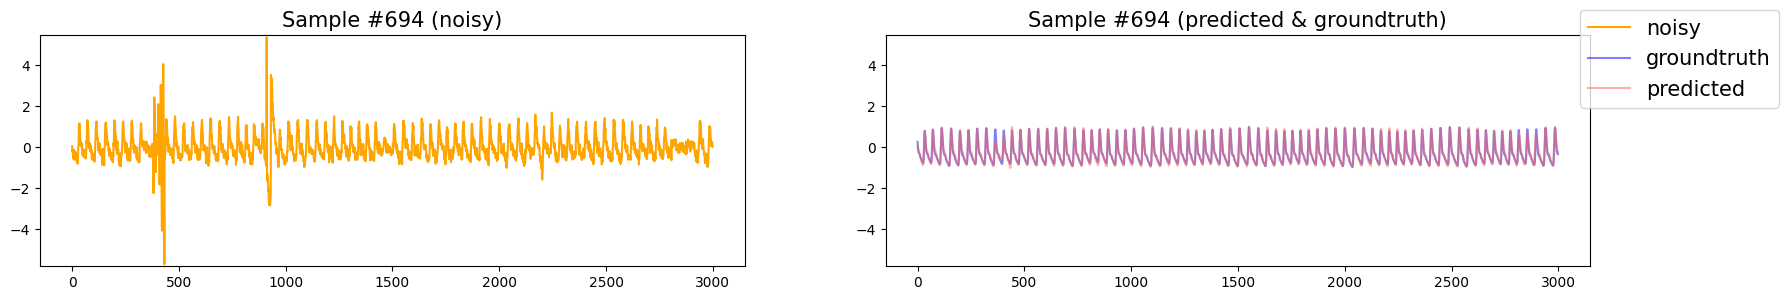

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 46: Train  0.5852921497503667


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46: Test  0.5890194483562908
New Best Model!


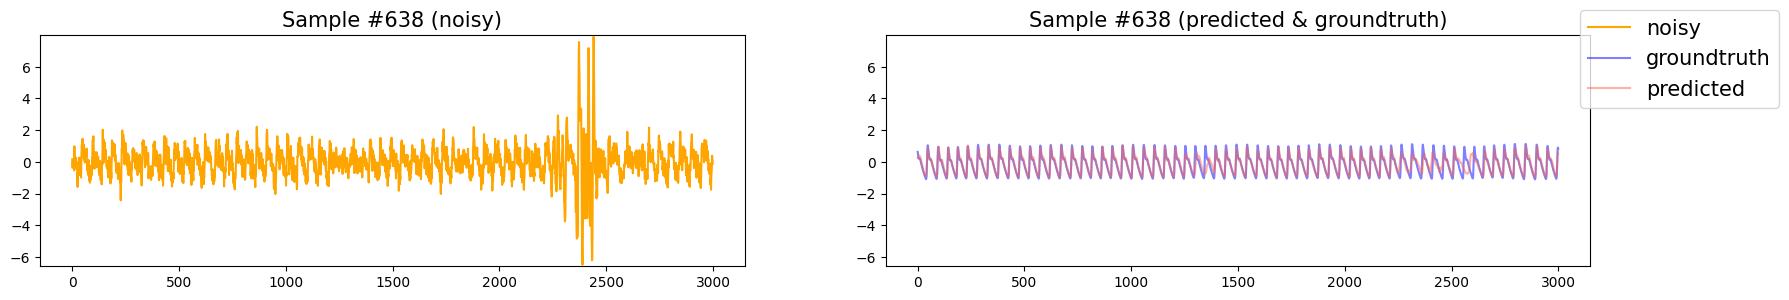

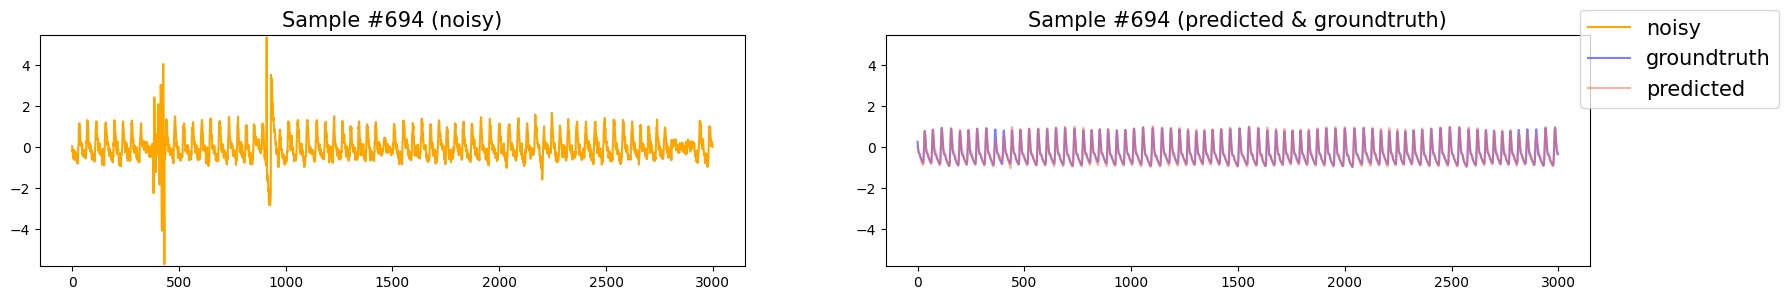

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 47: Train  0.5839183211233028


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47: Test  0.588313530504176
New Best Model!


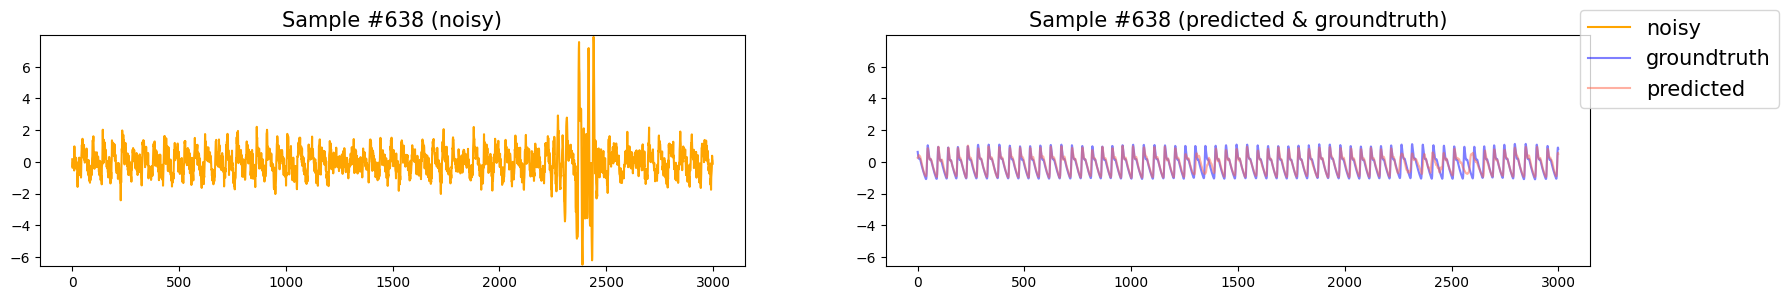

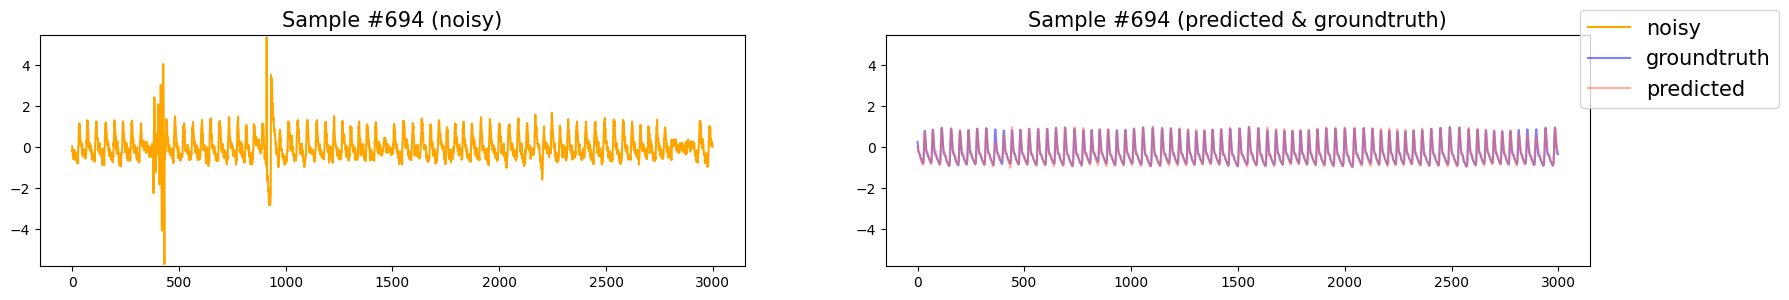

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 48: Train  0.5830616159379202


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48: Test  0.588187076349174
New Best Model!


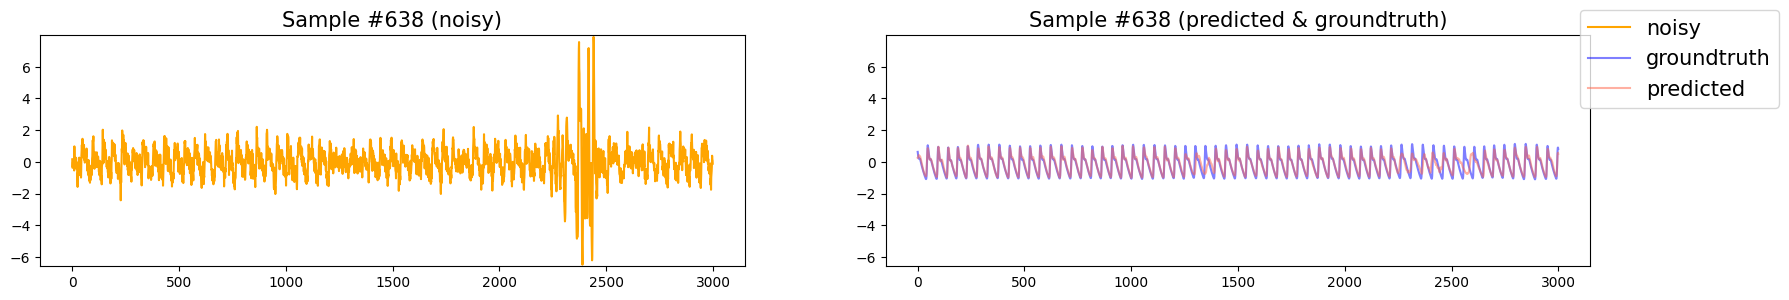

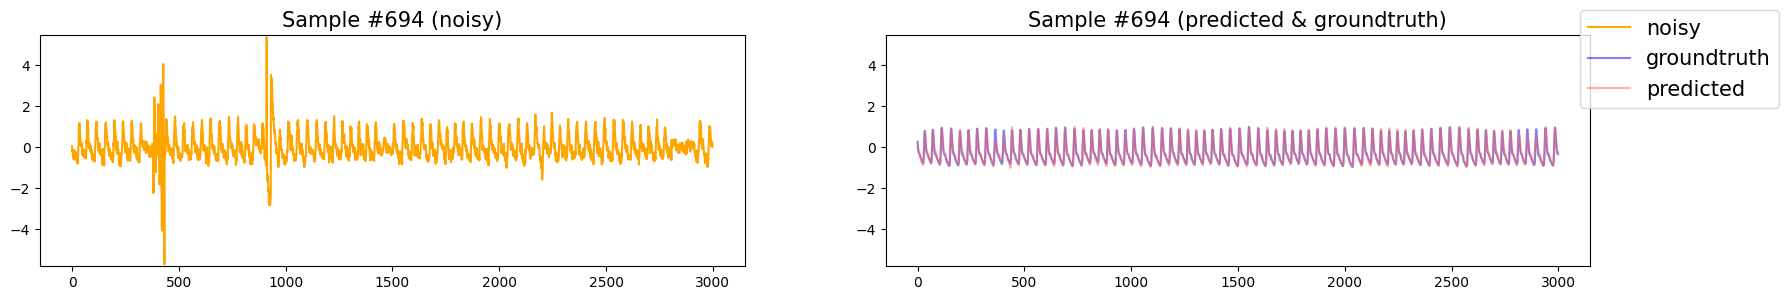

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 49: Train  0.5830537493412311


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49: Test  0.5881668413634848
New Best Model!


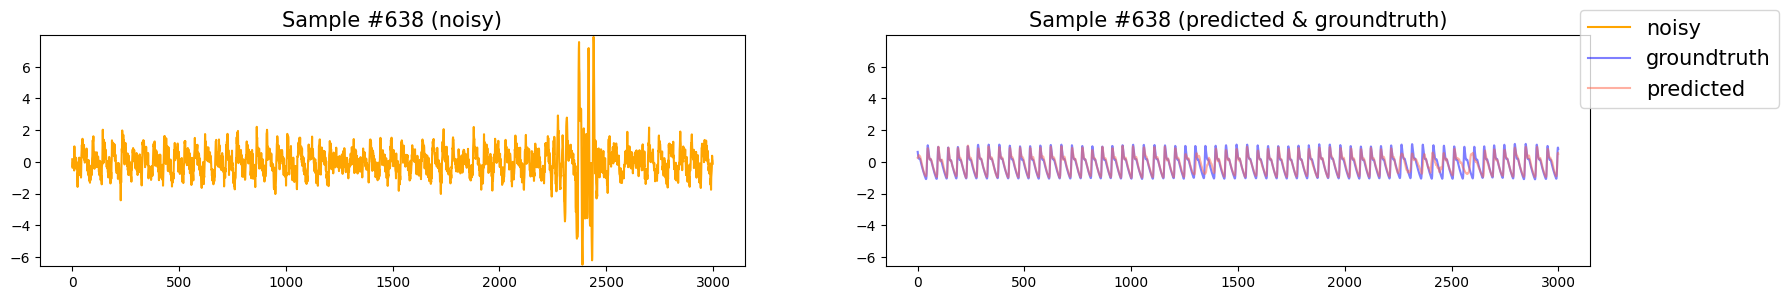

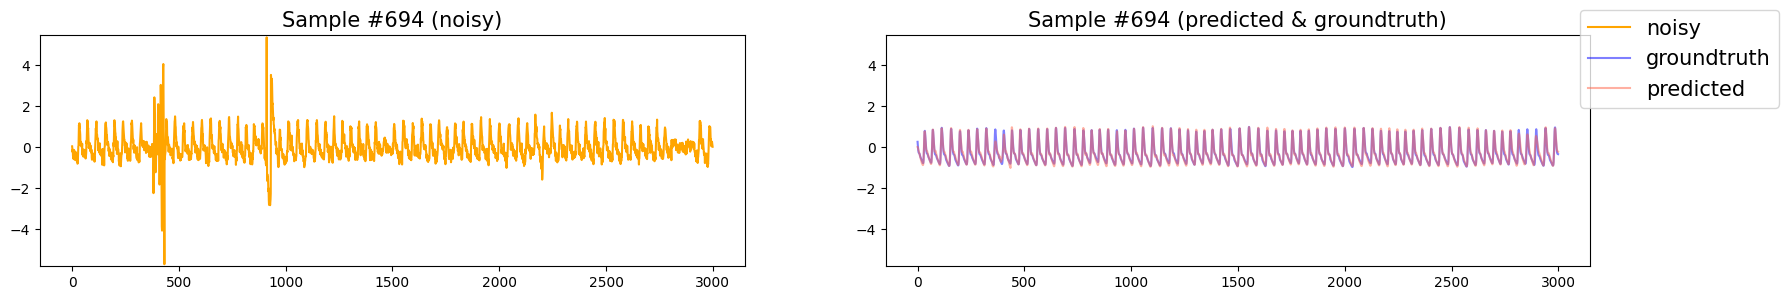

In [10]:
# Monitoring the prediction against the ground truth at each epoch allows us to
# assess how well the model is learning to trace the pulsation while suppressing artifacts.
# If the target performance is achieved before the maximum number of epochs,
# or if the loss stops decreasing, training can be terminated early.

import torch.optim as optim
opt = optim.Adam(model.parameters(), lr=1e-3)

max_epochs = 50
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*len(pulse_train), eta_min=1e-7)
best_val = 1e8

for i in range(max_epochs):
    print(f"Epoch {i}: Train ", epoch(pulse_train, model, opt, scheduler))
    val_loss = epoch(pulse_test, model)
    print(f"Epoch {i}: Test ", val_loss)
    if val_loss < best_val:
        print("New Best Model!")
        # This saves the model to the virtual machine's local file system in the Google Colab environment, which is temporary and gets wiped after the session ends.
        torch.save(model.state_dict(), "best_model_tmp.pt")

        # To save it to a specific folder:
        # torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/LSTM-pulse-tracing/model/best_model_tmp.pt")

        best_val = val_loss
        visualize_test(model)

In [15]:
# To save the best model from the virtual machine's local file system:
# We can also find it by clicking the folder icon on the left.

# Path where the best model was saved
local_model_path = "best_model_tmp.pt"

# Path in your Google Drive where you want to save the best model
drive_model_path = "/content/drive/MyDrive/Colab Notebooks/LSTM-pulse-tracing/model/"

# # Create the directory in Google Drive if it doesn't exist
!mkdir -p "{drive_model_path}"

# Copy the best model from local Colab storage to Google Drive
!cp "{local_model_path}" "{drive_model_path}"